# Notebook guide
This notebook walks through building a flight delay dataset by combining flight and weather APIs, engineering features, and training regression and classification models. It also documents data cleaning steps, model selection, and evaluation notes.


**Author:** Rashed  
**Date:** 2025-12-24


## Table of contents
- Flight delays and weather condition - Building the dataset


- Open Metro and AeroDataBox API Integration
  - Weather Data Retrieval using OpenMeteo API
  - AeroDataBox Flight Data Retrieval
  - Building the Final api call with Weather and Flight Data
- Feature Engineering
  - What we can do for a better model
  - Time Engineering
  - Airline Engineering
  - Airport Congestion Features
  - Route features
  - We can add interaction features
  - Log1p Transformation
  - Final Dataframe
- Training the Model
  - Handeling Missing Data
  - Preparing the Data
  - Linear Regression
  - LightGBM
  - XGBoost
  - Random Forest
  - CatBoost
  - Classification
  - LightGBM Classification
    - LightGBM (Multiclass) Results
  - Weighting Classes
  - CatBoost Classification
  - Training on GPUs
  - Handeling Missing Data
  - Threshold Selection
  - Creating the final model
  - Summary

# Flight delays and weather condition – Building the dataset

**Purpose**
- Explore data for flight delays and weather condition use cases
- Enrich flight data with weather information from Open-Meteo API
- Build a dataset for training machine learning models to predict flight delays
- Validate assumptions before adding API endpoints
- Prototype logic for FastAPI services


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/flight-delay-dataset-20182022")

print("Path to dataset files:", path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/FlightDelay
%ls

/content/drive/MyDrive/Colab Notebooks/FlightDelay
aeroapi-python/     full_df.parquet  __pycache__/       src/
aeromarket_api/     main.py          pyproject.toml     sublemmentary_folder/
bootstrap_paths.py  notebooks/       requirements.txt   weather.parquet
data/               openmeteo_api/   sample_df.parquet


In [ ]:
import pandas as pd
# We only need few columns for our analysis
KEEP_COLS = [
    # ---- Date & time (join keys) ----
    "FlightDate",
    "DepTimeBlk",

    # ---- Airports (for direction) ----
    "Origin",
    "Dest",

    # ---- Flight identity (API join) ----
    "IATA_Code_Operating_Airline",

    # ---- Targets / outcomes ----
    "DepDelayMinutes",

    # ---- Operational signal ----
    "Distance",
    "CRSElapsedTime",

    # ---- Cancellation info (to drop)----
    "Cancelled",

    # ---- Arrival time to calculate counts ----
    "ArrTimeBlk",

]

df_2018 = pd.read_parquet(f'{path}/Combined_Flights_2018.parquet', columns=KEEP_COLS)
df_2019 = pd.read_parquet(f'{path}/Combined_Flights_2019.parquet', columns=KEEP_COLS)
df_2020 = pd.read_parquet(f'{path}/Combined_Flights_2020.parquet', columns=KEEP_COLS)
df_2021 = pd.read_parquet(f'{path}/Combined_Flights_2021.parquet', columns=KEEP_COLS)
df_2022 = pd.read_parquet(f'{path}/Combined_Flights_2022.parquet', columns=KEEP_COLS)

Now we will need to concatenate the data from different years into a single DataFrame for easier analysis.

In [ ]:
df = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 10 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   FlightDate                   datetime64[us]
 1   DepTimeBlk                   object        
 2   Origin                       object        
 3   Dest                         object        
 4   IATA_Code_Operating_Airline  object        
 5   DepDelayMinutes              float64       
 6   Distance                     float64       
 7   CRSElapsedTime               float64       
 8   Cancelled                    bool          
 9   ArrTimeBlk                   object        
dtypes: bool(1), datetime64[us](1), float64(3), object(5)
memory usage: 2.0+ GB


In [ ]:
df.describe()

,FlightDate,DepDelayMinutes,Distance,CRSElapsedTime
count,29193782,2.843070e+07,2.919378e+07,2.919376e+07
mean,2020-04-23 22:27:03.485606,1.278311e+01,7.797346e+02,1.387605e+02
min,2018-01-01 00:00:00,0.000000e+00,1.600000e+01,-2.920000e+02
25%,2019-03-18 00:00:00,0.000000e+00,3.540000e+02,8.800000e+01
50%,2020-02-08 00:00:00,0.000000e+00,6.260000e+02,1.210000e+02
75%,2021-07-17 00:00:00,5.000000e+00,1.014000e+03,1.690000e+02
max,2022-07-31 00:00:00,7.223000e+03,5.812000e+03,1.645000e+03
std,NaN,4.617337e+01,5.812739e+02,7.077316e+01


In [ ]:
# TODO: do not train the model, until you make sure that you can obtain distance and CRSElapsedTime from the API
df.head()

,FlightDate,DepTimeBlk,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,Cancelled,ArrTimeBlk
0,2018-01-23,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,False,1300-1359
1,2018-01-24,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,False,1300-1359
2,2018-01-25,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,False,1300-1359
3,2018-01-26,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,False,1300-1359
4,2018-01-27,1400-1459,ABY,ATL,9E,0.0,145.0,60.0,False,1500-1559


Our goal is to predict delay, so we do not need cancelled flights. We will filter them out during the data loading phase.

In [ ]:
df = df[df['Cancelled'] == 0].copy()
df.drop(columns=['Cancelled'], inplace=True)
df.head()

,FlightDate,DepTimeBlk,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,ArrTimeBlk
0,2018-01-23,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,1300-1359
1,2018-01-24,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,1300-1359
2,2018-01-25,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,1300-1359
3,2018-01-26,1200-1259,ABY,ATL,9E,0.0,145.0,62.0,1300-1359
4,2018-01-27,1400-1459,ABY,ATL,9E,0.0,145.0,60.0,1500-1559


In [ ]:
df.shape

(28416515, 9)

**Update**: This version focuses on predicting 1-hour departure delay risk for flights that operate. Cancellations were excluded to avoid mixing fundamentally different operational outcomes. Future versions will incorporate cancellation risk as part of a unified disruption metric.

Let's refine the date & time columns for departure and arrival times to create a proper datetime representation.

In [ ]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
df['Hour'] = df['DepTimeBlk'].str.slice(0, 2).astype(int)
df.drop(columns=['DepTimeBlk'], inplace=True)
df["datetime"] = (
    df["FlightDate"]
    + pd.to_timedelta(df["Hour"], unit="h")
)
df.head()

,FlightDate,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,ArrTimeBlk,Hour,datetime
0,2018-01-23,ABY,ATL,9E,0.0,145.0,62.0,1300-1359,12,2018-01-23 12:00:00
1,2018-01-24,ABY,ATL,9E,0.0,145.0,62.0,1300-1359,12,2018-01-24 12:00:00
2,2018-01-25,ABY,ATL,9E,0.0,145.0,62.0,1300-1359,12,2018-01-25 12:00:00
3,2018-01-26,ABY,ATL,9E,0.0,145.0,62.0,1300-1359,12,2018-01-26 12:00:00
4,2018-01-27,ABY,ATL,9E,0.0,145.0,60.0,1500-1559,14,2018-01-27 14:00:00


In [ ]:
df['Hour_Arrival'] = df['ArrTimeBlk'].str.slice(0, 2).astype(int)
df['arrival_next_day'] = df['Hour_Arrival'] < df['Hour']
df["arr_datetime"] = (
    df["FlightDate"]
    + pd.to_timedelta(df["Hour_Arrival"], unit="h")
    + pd.to_timedelta(df["arrival_next_day"].astype(int), unit="D")
)
df.drop(columns=['ArrTimeBlk', 'Hour_Arrival', 'arrival_next_day', 'Hour', 'FlightDate'], inplace=True)


In [ ]:
df.head(3)

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,datetime,arr_datetime
0,ABY,ATL,9E,0.0,145.0,62.0,2018-01-23 12:00:00,2018-01-23 13:00:00
1,ABY,ATL,9E,0.0,145.0,62.0,2018-01-24 12:00:00,2018-01-24 13:00:00
2,ABY,ATL,9E,0.0,145.0,62.0,2018-01-25 12:00:00,2018-01-25 13:00:00
3,ABY,ATL,9E,0.0,145.0,62.0,2018-01-26 12:00:00,2018-01-26 13:00:00
4,ABY,ATL,9E,0.0,145.0,60.0,2018-01-27 14:00:00,2018-01-27 15:00:00


In order to calculate the number of flights departing from an airport, and arriving to the same airport, within the same hour, we need to group by the origin and deparuture datetime, and then do the same for arrival. Then we can add these counts as new features to the main dataframe.

First, we will group by 'Origin' and 'datetime' to get the count of departures per hour for each airport.

In [ ]:
dep_counts = (
    df.groupby(["Origin", "datetime"])
      .size()
      .reset_index(name="departures_per_hour")
      .rename(columns={"Origin": "airport", "datetime": "hour"})
)

arr_counts = (
    df.groupby(["Dest", "arr_datetime"])
      .size()
      .reset_index(name="arrivals_per_hour")
      .rename(columns={"Dest": "airport", "arr_datetime": "hour"})
)


In [ ]:
dep_counts.head()

,airport,hour,departures_per_hour
0,ABE,2018-01-01 06:00:00,2
1,ABE,2018-01-01 09:00:00,2
2,ABE,2018-01-01 17:00:00,1
3,ABE,2018-01-01 20:00:00,1
4,ABE,2018-01-02 06:00:00,3


In [ ]:
arr_counts.head()

,airport,hour,arrivals_per_hour
0,ABE,2018-01-01 09:00:00,1
1,ABE,2018-01-01 16:00:00,1
2,ABE,2018-01-01 17:00:00,2
3,ABE,2018-01-01 19:00:00,1
4,ABE,2018-01-01 22:00:00,1


In [ ]:
congestion = (
    dep_counts
    .merge(
        arr_counts,
        on=["airport", "hour"],
        how="outer"
    )
    .fillna(0)
)

congestion["scheduled_congestion"] = (
    congestion["departures_per_hour"]
    + congestion["arrivals_per_hour"]
)

congestion.head(10)

,airport,hour,departures_per_hour,arrivals_per_hour,scheduled_congestion
0,ABE,2018-01-01 06:00:00,2.0,0.0,2.0
1,ABE,2018-01-01 09:00:00,2.0,1.0,3.0
2,ABE,2018-01-01 16:00:00,0.0,1.0,1.0
3,ABE,2018-01-01 17:00:00,1.0,2.0,3.0
4,ABE,2018-01-01 19:00:00,0.0,1.0,1.0
5,ABE,2018-01-01 20:00:00,1.0,0.0,1.0
6,ABE,2018-01-01 22:00:00,0.0,1.0,1.0
7,ABE,2018-01-02 06:00:00,3.0,0.0,3.0
8,ABE,2018-01-02 09:00:00,1.0,1.0,2.0
9,ABE,2018-01-02 15:00:00,0.0,1.0,1.0


In [ ]:
congestion[congestion['scheduled_congestion'] == 132]

,airport,hour,departures_per_hour,arrivals_per_hour,scheduled_congestion
294598,ATL,2018-01-02 14:00:00,51.0,81.0,132.0
294699,ATL,2018-01-07 20:00:00,48.0,84.0,132.0
294801,ATL,2018-01-13 08:00:00,44.0,88.0,132.0
294820,ATL,2018-01-14 08:00:00,53.0,79.0,132.0
294851,ATL,2018-01-15 20:00:00,42.0,90.0,132.0
...,...,...,...,...,...
4423238,ORD,2022-06-23 18:00:00,53.0,79.0,132.0
4423252,ORD,2022-06-24 13:00:00,71.0,61.0,132.0
4423371,ORD,2022-06-30 18:00:00,49.0,83.0,132.0
4423637,ORD,2022-07-14 18:00:00,54.0,78.0,132.0


Now let's merge these counts back into the main dataframe.

In [ ]:
df = df.merge(
    congestion[["airport", "hour", "scheduled_congestion"]],
    left_on=["Origin", "datetime"],
    right_on=["airport", "hour"],
    how="left",
    validate="many_to_one"
)
df

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,datetime,arr_datetime,airport,hour,scheduled_congestion
0,ABY,ATL,9E,0.0,145.0,62.0,2018-01-23 12:00:00,2018-01-23 13:00:00,ABY,2018-01-23 12:00:00,1.0
1,ABY,ATL,9E,0.0,145.0,62.0,2018-01-24 12:00:00,2018-01-24 13:00:00,ABY,2018-01-24 12:00:00,1.0
2,ABY,ATL,9E,0.0,145.0,62.0,2018-01-25 12:00:00,2018-01-25 13:00:00,ABY,2018-01-25 12:00:00,1.0
3,ABY,ATL,9E,0.0,145.0,62.0,2018-01-26 12:00:00,2018-01-26 13:00:00,ABY,2018-01-26 12:00:00,1.0
4,ABY,ATL,9E,0.0,145.0,60.0,2018-01-27 14:00:00,2018-01-27 15:00:00,ABY,2018-01-27 14:00:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...
28416510,EWR,MEM,YX,154.0,946.0,182.0,2022-03-19 20:00:00,2022-03-19 22:00:00,EWR,2022-03-19 20:00:00,30.0
28416511,MSY,EWR,YX,25.0,1167.0,185.0,2022-03-31 19:00:00,2022-03-31 23:00:00,MSY,2022-03-31 19:00:00,11.0
28416512,ALB,ORD,YX,378.0,723.0,158.0,2022-03-08 17:00:00,2022-03-08 18:00:00,ALB,2022-03-08 17:00:00,6.0
28416513,EWR,PIT,YX,113.0,319.0,86.0,2022-03-25 21:00:00,2022-03-25 22:00:00,EWR,2022-03-25 21:00:00,34.0


In [ ]:
df[df['scheduled_congestion'] == 132]

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,datetime,arr_datetime,airport,hour,scheduled_congestion
563,ATL,FAY,9E,0.0,331.0,76.0,2018-01-13 08:00:00,2018-01-13 09:00:00,ATL,2018-01-13 08:00:00,132.0
564,ATL,FAY,9E,8.0,331.0,78.0,2018-01-14 08:00:00,2018-01-14 09:00:00,ATL,2018-01-14 08:00:00,132.0
576,ATL,FAY,9E,47.0,331.0,76.0,2018-01-27 08:00:00,2018-01-27 09:00:00,ATL,2018-01-27 08:00:00,132.0
657,ATL,FSM,9E,0.0,579.0,123.0,2018-01-02 14:00:00,2018-01-02 15:00:00,ATL,2018-01-02 14:00:00,132.0
1235,ATL,FAY,9E,0.0,331.0,75.0,2018-01-25 13:00:00,2018-01-25 14:00:00,ATL,2018-01-25 13:00:00,132.0
...,...,...,...,...,...,...,...,...,...,...,...
28415352,ORD,MSN,YX,18.0,109.0,57.0,2022-03-28 09:00:00,2022-03-28 10:00:00,ORD,2022-03-28 09:00:00,132.0
28416213,ORD,PIT,YX,9.0,413.0,95.0,2022-03-31 18:00:00,2022-03-31 21:00:00,ORD,2022-03-31 18:00:00,132.0
28416240,ORD,IND,YX,0.0,177.0,72.0,2022-03-31 18:00:00,2022-03-31 20:00:00,ORD,2022-03-31 18:00:00,132.0
28416330,ORD,CMH,YX,0.0,296.0,85.0,2022-03-31 18:00:00,2022-03-31 21:00:00,ORD,2022-03-31 18:00:00,132.0


**Update**: It has been realized that even the arrival congestion affect departure delay, so it has been added here.

In [ ]:
import pandas as pd

In [ ]:
full_df = pd.read_parquet("./data/full_df_v2.parquet")

In [ ]:
full_df.columns

Index(['Origin', 'Dest', 'IATA_Code_Operating_Airline', 'DepDelayMinutes',
       'Distance', 'CRSElapsedTime', 'arr_datetime', 'scheduled_congestion',
       'dep_snowfall', 'dep_rain', 'dep_precipitation', 'dep_wind_speed_10m',
       'dep_wind_gusts_10m', 'dep_cloud_cover_low', 'dep_cloud_cover',
       'dep_temperature_2m', 'dep_apparent_temperature',
       'dep_surface_pressure', 'dep_relative_humidity_2m', 'dep_pressure_msl',
       'dep_date_local', 'arr_date', 'arr_snowfall', 'arr_rain',
       'arr_precipitation', 'arr_wind_speed_10m', 'arr_wind_gusts_10m',
       'arr_cloud_cover_low', 'arr_cloud_cover', 'arr_temperature_2m',
       'arr_apparent_temperature', 'arr_surface_pressure',
       'arr_relative_humidity_2m', 'arr_pressure_msl'],
      dtype='object')

In [ ]:
full_df = full_df.rename(columns={'scheduled_congestion': 'dep_scheduled_congestion'})

In [ ]:
full_df.head(1)['arr_datetime']

,arr_datetime
0,2018-01-23 13:00:00


In [ ]:
dep_counts = (
    full_df.groupby(["Origin", "dep_date_local"])
      .size()
      .reset_index(name="departures_per_hour")
      .rename(columns={"Origin": "airport", "dep_date_local": "hour"})
)

arr_counts = (
    full_df.groupby(["Dest", "arr_datetime"])
      .size()
      .reset_index(name="arrivals_per_hour")
      .rename(columns={"Dest": "airport", "arr_datetime": "hour"})
)


In [ ]:
congestion = (
    dep_counts
    .merge(
        arr_counts,
        on=["airport", "hour"],
        how="outer"
    )
    .fillna(0)
)

congestion["scheduled_congestion"] = (
    congestion["departures_per_hour"]
    + congestion["arrivals_per_hour"]
)
congestion.head(6)

,airport,hour,departures_per_hour,arrivals_per_hour,scheduled_congestion
0,ABE,2018-01-01 06:00:00,2.0,0.0,2.0
1,ABE,2018-01-01 09:00:00,2.0,1.0,3.0
2,ABE,2018-01-01 16:00:00,0.0,1.0,1.0
3,ABE,2018-01-01 17:00:00,1.0,2.0,3.0
4,ABE,2018-01-01 19:00:00,0.0,1.0,1.0
5,ABE,2018-01-01 20:00:00,1.0,0.0,1.0


In [ ]:
full_df = full_df.merge(
    congestion[["airport", "hour", "scheduled_congestion"]],
    left_on=["Dest", "arr_datetime"],
    right_on=["airport", "hour"],
    how="left",
    validate="many_to_one"
)

In [ ]:
cols_to_drop = ['airport', 'hour']
full_df.drop(columns=cols_to_drop, inplace=True)
full_df.rename(columns={'scheduled_congestion': 'arr_scheduled_congestion'}, inplace=True)

In [ ]:
sample_df = full_df.sample(n=100000, random_state=42)

In [ ]:
sample_df.to_parquet("./data/sample_df_v3.parquet")
full_df.to_parquet("./data/full_df_v3.parquet")

Now we can include weather data into our dataset. These classes were created in order to simplify the apis calls on the notebook.

In [ ]:
%%capture
!pip install -r requirements.txt

In [ ]:
from openmeteo_api.src.openmeteoapi.WeatherData import Weather
from openmeteo_api.src.openmeteoapi.APICaller import OpenMeteoAPICaller
import os
from dotenv import load_dotenv

The flight delay dataset is from 2018 to 2022, so all we need to do is getting the weather data for this range of time for each unique airpor, and then join them together.

In [ ]:
print(set(df['Origin'].unique()) == set(df['Dest'].unique()))
print(len(set(df['Origin'].unique())))
# print(df[df['Origin']== "ISN"])

True
388


In [ ]:
from tqdm import tqdm
import time

BATCH_SIZE = 10
length = len(set(df['Origin'].unique()))
airports = list(df['Origin'].unique())
start_date = "2018-01-01"
end_date = "2022-12-31"
api_caller_weather = OpenMeteoAPICaller()

dfs = []

for i in tqdm(range(0, length, BATCH_SIZE)):
    airport_list = airports[i:i+BATCH_SIZE]
    print(airport_list)
    if len(airport_list) == 0: break
    w = Weather(
        api_caller=api_caller_weather,
        airport_code=airport_list,
        code_type="iata",
        start_date=start_date,
        end_date=end_date,
    )

    for attempt in range(3):
        try:
            df_weather = w.to_hourly_dataframe()
            dfs.append(df_weather)
            break
        except Exception as e:
            if "limit" in str(e).lower():
                time.sleep(60)
            else:
                raise

    time.sleep(5)

weather_df = pd.concat(dfs, ignore_index=True)

In [ ]:
weather_df = pd.read_parquet("./data/weather_01022026_V3_big.parquet")

In [ ]:
weather_df[weather_df["queried_airport_code"] == "JFK"].head(3)

,date,snowfall,rain,precipitation,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code
6840432,2017-12-31 22:00:00-07:00,0.0,0.0,0.0,18.59845,32.399998,0.0,0.0,-13.1,-19.658886,1026.895264,51.989731,1027.300049,JFK
6840433,2017-12-31 23:00:00-07:00,0.0,0.0,0.0,18.11841,31.319998,0.0,0.0,-13.3,-19.781853,1027.194824,53.764278,1027.599976,JFK
6840434,2018-01-01 00:00:00-07:00,0.0,0.0,0.0,18.11841,30.599998,0.0,0.0,-13.5,-19.981882,1027.594238,54.644852,1028.000000,JFK


In [ ]:
weather_df["date_local"] = weather_df["date"].dt.tz_localize(None)

In [ ]:
weather_df.head(3)

,date,snowfall,rain,precipitation,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code,date_local
0,2017-01-31 00:00:00-07:00,0.0,0.0,0.0,17.283749,31.319998,0.0,26.0,1.55,-3.807626,841.166260,59.465061,1024.800049,ABQ,2017-01-31 00:00:00
1,2017-01-31 01:00:00-07:00,0.0,0.0,0.0,10.446206,27.000000,0.0,21.0,0.05,-4.299987,840.681946,66.755997,1025.300049,ABQ,2017-01-31 01:00:00
2,2017-01-31 02:00:00-07:00,0.0,0.0,0.0,4.802999,16.199999,0.0,30.0,-0.20,-3.811146,840.859680,63.962601,1025.699951,ABQ,2017-01-31 02:00:00


## Duplicates
One problem that we would face when collecting weather data is daylight saving. For example,

In [ ]:
weather_df[weather_df.duplicated(subset=["queried_airport_code", "date_local"])]

,date,snowfall,rain,precipitation,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code,date_local
6673,2017-11-05 01:00:00-07:00,0.0,0.0,0.0,11.841756,19.080000,0.0,0.0,11.6500,8.442201,837.136108,58.163963,1012.900024,ABQ,2017-11-05 01:00:00
14738,2017-11-05 01:00:00-07:00,0.0,0.0,0.0,14.291592,28.080000,0.0,39.0,-1.6500,-6.763009,967.247986,64.854851,1016.299988,ABR,2017-11-05 01:00:00
22800,2017-11-05 01:00:00-07:00,0.0,0.0,0.0,9.346143,20.519999,1.0,4.0,4.9500,2.038206,1011.125061,89.389397,1018.599976,ACV,2017-11-05 01:00:00
30866,2017-11-05 01:00:00-07:00,0.0,0.0,0.0,14.400000,24.840000,100.0,100.0,22.5000,24.967684,1012.389221,93.223862,1015.200012,AEX,2017-11-05 01:00:00
38928,2017-11-05 01:00:00-07:00,0.0,0.2,0.2,11.983188,20.880001,0.0,97.0,5.1500,0.807792,967.731445,54.021641,1010.900024,ALW,2017-11-05 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19381464,2018-11-04 01:00:00-07:00,0.0,0.0,0.0,2.620839,19.799999,0.0,95.0,16.9505,14.088112,880.911682,26.388680,1018.900024,BIH,2018-11-04 01:00:00
19390200,2019-11-03 01:00:00-07:00,0.0,0.0,0.0,4.896529,13.320000,0.0,0.0,15.7005,11.573908,880.364807,13.520775,1018.900024,BIH,2019-11-03 01:00:00
19398936,2020-11-01 01:00:00-07:00,0.0,0.0,0.0,5.001280,14.040000,0.0,0.0,18.1005,13.779694,883.833252,9.132733,1021.700012,BIH,2020-11-01 01:00:00
19407840,2021-11-07 01:00:00-07:00,0.0,0.0,0.0,9.449572,28.080000,0.0,0.0,9.5505,5.935616,873.216919,48.630173,1013.799988,BIH,2021-11-07 01:00:00


Can you notice something in these duplicated items? They are all in daylight saving time. When we request the data from the open meteo api in local time, it gives the correct time with the correct offset, but when stored just the date and time in date_local without the offset, it remains duplicated, but we are only interested in the time after the DST, because flights set the take off time according to the new time. Let's remove the duplicate and keep only updated time.

In [ ]:
weather_df = (
    weather_df
    .sort_values("date")
    .drop_duplicates(
        subset=["queried_airport_code", "date_local"],
        keep="last"
    )
)


In [ ]:
assert not weather_df.duplicated(
    ["queried_airport_code", "date_local"]
).any()


In [ ]:
full_df = df.merge(weather_df, left_on=["Origin", "datetime"], right_on=["queried_airport_code", "date_local"], how="left")

In [ ]:
full_df.head(3)

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,datetime,arr_datetime,airport,hour,...,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code,date_local
0,ABY,ATL,9E,0.0,145.0,62.0,2018-01-23 12:00:00,2018-01-23 13:00:00,ABY,2018-01-23 12:00:00,...,36.360001,0.0,88.0,17.049999,13.199808,1009.687012,31.722488,1016.599976,ABY,2018-01-23 12:00:00
1,ABY,ATL,9E,0.0,145.0,62.0,2018-01-24 12:00:00,2018-01-24 13:00:00,ABY,2018-01-24 12:00:00,...,31.680000,0.0,88.0,14.000000,10.193374,1017.161560,34.573521,1024.199951,ABY,2018-01-24 12:00:00
2,ABY,ATL,9E,0.0,145.0,62.0,2018-01-25 12:00:00,2018-01-25 13:00:00,ABY,2018-01-25 12:00:00,...,30.599998,0.0,33.0,15.200000,11.500547,1024.242065,26.188848,1031.300049,ABY,2018-01-25 12:00:00


In [ ]:
display(len(full_df) == len(df))

True

In [ ]:
df.isna().sum()

,0
Origin,0
Dest,0
IATA_Code_Operating_Airline,0
DepDelayMinutes,1113
Distance,0
CRSElapsedTime,4
datetime,0
arr_datetime,0
airport,0
hour,0


In [ ]:
full_df.isna().sum()

,0
Origin,0
Dest,0
IATA_Code_Operating_Airline,0
DepDelayMinutes,1113
Distance,0
CRSElapsedTime,4
datetime,0
arr_datetime,0
airport,0
hour,0


Before saving the Dataset, it would be a good idea to drop the features that were created for dataset construction purposes.

In [ ]:
full_df.columns
col_to_drop = ['datetime', 'queried_airport_code', "airport", "hour", "date"]
full_df.drop(columns=col_to_drop, inplace=True)

In [ ]:
full_df.head()

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,scheduled_congestion,snowfall,rain,...,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,date_local
0,ABY,ATL,9E,0.0,145.0,62.0,2018-01-23 13:00:00,1.0,0.0,0.0,...,15.905319,36.360001,0.0,88.0,17.049999,13.199808,1009.687012,31.722488,1016.599976,2018-01-23 12:00:00
1,ABY,ATL,9E,0.0,145.0,62.0,2018-01-24 13:00:00,1.0,0.0,0.0,...,13.493999,31.680000,0.0,88.0,14.000000,10.193374,1017.161560,34.573521,1024.199951,2018-01-24 12:00:00
2,ABY,ATL,9E,0.0,145.0,62.0,2018-01-25 13:00:00,1.0,0.0,0.0,...,12.096214,30.599998,0.0,33.0,15.200000,11.500547,1024.242065,26.188848,1031.300049,2018-01-25 12:00:00
3,ABY,ATL,9E,0.0,145.0,62.0,2018-01-26 13:00:00,1.0,0.0,0.0,...,17.106628,38.519997,9.0,86.0,18.100000,14.929314,1024.808716,46.488724,1031.800049,2018-01-26 12:00:00
4,ABY,ATL,9E,0.0,145.0,60.0,2018-01-27 15:00:00,1.0,0.0,0.0,...,11.988594,36.360001,100.0,100.0,20.799999,19.435747,1017.820312,54.349552,1024.699951,2018-01-27 14:00:00


Also, it is better to do our experiments in a small set of data for better computational runtime, and then train the final model on full dataset

In [ ]:
sample_df = full_df.sample(n=100000, random_state=42)

In [ ]:
full_df.to_parquet("./data/full_df.parquet")
sample_df.to_parquet("./data/sample_df.parquet")

**Update**: It has been realized that arrival weather affect delay even more than Dep Weather, so it has been added here.

In [ ]:
import pandas as pd

In [ ]:
full_df = pd.read_parquet("./data/full_df.parquet")
weather_df = pd.read_parquet("./data/weather_01022026_V3_big.parquet")

In [ ]:
airports = ['ITO', 'LIH', 'KOA', 'OGG']
start_date = "2017-12-30"
end_date = "2018-01-02"

api_caller_weather = OpenMeteoAPICaller()

w = Weather(
    api_caller=api_caller_weather,
    airport_code=airports,
    code_type="iata",
    start_date=start_date,
    end_date=end_date,
)
updated_df = w.to_hourly_dataframe()['data']

Fetching weather data from: https://archive-api.open-meteo.com/v1/archive
Successfully fetched data for 4 airport(s).


In [ ]:
weather_df["date"] = pd.to_datetime(weather_df["date"])
updated_df['date'] = pd.to_datetime(updated_df['date'])
weather_df["date_local"] = weather_df["date"].dt.tz_localize(None)
updated_df["date_local"] = updated_df["date"].dt.tz_localize(None)

In [ ]:
weather_df = pd.concat([weather_df, updated_df], ignore_index=True)

In [ ]:
weather_df.head(2)

,date,snowfall,rain,precipitation,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code,date_local
0,2017-01-31 00:00:00-07:00,0.0,0.0,0.0,17.283749,31.319998,0.0,26.0,1.55,-3.807626,841.166260,59.465061,1024.800049,ABQ,2017-01-31 00:00:00
1,2017-01-31 01:00:00-07:00,0.0,0.0,0.0,10.446206,27.000000,0.0,21.0,0.05,-4.299987,840.681946,66.755997,1025.300049,ABQ,2017-01-31 01:00:00


In [ ]:
weather_df = (
    weather_df
    .sort_values("date")
    .drop_duplicates(
        subset=["queried_airport_code", "date_local"],
        keep="last"
    )
)

In [ ]:
arr_weather = weather_df.copy()
arr_weather = arr_weather.add_prefix("arr_")
arr_weather.head(2)

,arr_date,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_queried_airport_code,arr_date_local
266112,2017-01-30 23:00:00-07:00,0.0,0.0,0.0,15.077082,30.239998,0.0,0.0,8.70,4.768111,993.656677,64.382835,1017.0,HSV,2017-01-30 23:00:00
596736,2017-01-30 23:00:00-07:00,0.0,0.0,0.0,14.764390,24.119999,0.0,0.0,12.25,8.745193,1010.128967,58.518990,1018.5,SHV,2017-01-30 23:00:00


In [ ]:
full_df = full_df.merge(arr_weather, left_on=["Dest", "arr_datetime"], right_on=["arr_queried_airport_code", "arr_date_local"], how="left")

In [ ]:
full_df['arr_cloud_cover'].isna().sum()

np.int64(0)

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28416515 entries, 0 to 28416514
Data columns (total 36 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   Origin                       object        
 1   Dest                         object        
 2   IATA_Code_Operating_Airline  object        
 3   DepDelayMinutes              float64       
 4   Distance                     float64       
 5   CRSElapsedTime               float64       
 6   arr_datetime                 datetime64[ns]
 7   scheduled_congestion         float64       
 8   snowfall                     float32       
 9   rain                         float32       
 10  precipitation                float32       
 11  wind_speed_10m               float32       
 12  wind_gusts_10m               float32       
 13  cloud_cover_low              float32       
 14  cloud_cover                  float32       
 15  temperature_2m               float32       
 16

In [ ]:
dep_rename_map = {
    "snowfall": "dep_snowfall",
    "rain": "dep_rain",
    "precipitation": "dep_precipitation",
    "wind_speed_10m": "dep_wind_speed_10m",
    "wind_gusts_10m": "dep_wind_gusts_10m",
    "cloud_cover_low": "dep_cloud_cover_low",
    "cloud_cover": "dep_cloud_cover",
    "temperature_2m": "dep_temperature_2m",
    "apparent_temperature": "dep_apparent_temperature",
    "surface_pressure": "dep_surface_pressure",
    "relative_humidity_2m": "dep_relative_humidity_2m",
    "pressure_msl": "dep_pressure_msl",
    "date_local": "dep_date_local",
}
cols_to_drop = ['arr_queried_airport_code', 'arr_date_local']
full_df = full_df.rename(columns=dep_rename_map)


In [ ]:
full_df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
display(full_df.head(1), full_df[full_df['arr_snowfall'].isna()])

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,scheduled_congestion,dep_snowfall,dep_rain,...,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl
0,ABY,ATL,9E,0.0,145.0,62.0,2018-01-23 13:00:00,1.0,0.0,0.0,...,0.0,22.819571,43.560001,0.0,69.0,11.9,6.463589,979.427368,44.244251,1015.400024


,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,scheduled_congestion,dep_snowfall,dep_rain,...,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl


In [ ]:
full_df.to_parquet("./data/full_df_v2.parquet")

In [ ]:
sample_df = full_df.sample(n=100000, random_state=42)

In [ ]:
sample_df.to_parquet("./data/sample_df_v2.parquet")

This concludes our approach to modifying the dataset. Let's move on to engineering the data for better model accuracy

# Open Metro and AeroDataBox API Integration

The purpose of this section is to explore the integration of Open Metro and AeroDataBox APIs for retrieving weather and flight data. The methodology that I used to explore these APIs is as follows:
* Create aeromarket-api and openmeteo-api packages to interact with the respective APIs more easily.
* Use environment variables to securely store API keys and URLs.
* Implement classes and methods to fetch and process data from both APIs. 

In [ ]:
# Executing this cell does some magic
%load_ext autoreload
%autoreload 2

In [ ]:
%cd ..

In [ ]:
from openmeteo_api.src.openmeteoapi.WeatherData import Weather
from openmeteo_api.src.openmeteoapi.APICaller import OpenMeteoAPICaller
from aeromarket_api.src.aeroapi_market.APICaller import APICaller
from aeromarket_api.src.aeroapi_market.Flights import Flights
import pandas as pd
import os
from dotenv import load_dotenv

As a reminder, our goal is to get a dataset with the following format:

In [ ]:
sample_df = pd.read_parquet("./data/sample_df_v3.parquet")

In [ ]:
sample_df.head(2)

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,dep_scheduled_congestion,dep_snowfall,dep_rain,...,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_scheduled_congestion
24296413,SEA,SMF,AS,10.0,605.0,115.0,2021-06-28 08:00:00,28.0,0.0,0.0,...,11.298495,24.84,0.0,0.0,16.6,15.752708,1006.069519,76.995392,1006.900024,17.0
8823672,DSM,DEN,UA,0.0,589.0,116.0,2019-09-15 18:00:00,9.0,0.0,0.0,...,15.188416,42.48,0.0,100.0,28.4,24.027100,840.228271,15.589545,1008.099976,75.0


# Weather Data Retrieval using OpenMeteo API

To retrieve weather data, I created a `Weather` class in the `openmeteo-api` package. This class uses an `APICaller` to make requests to the OpenMeteo API and fetch historical weather data based on specified parameters such as latitude, longitude, start date, end date, and hourly variables. These data will be very helpful for the model to predict flight delays based on weather conditions.


I defined the disiered weather variables in the weather class for easier readability. Alternatively, you can specify the variables directly when calling the methods. The desired weather variables are as follows:
- Temperature at 2 meters (°C)
- Precipitation (mm)
- Wind Speed at 10 meters (km/h)
- Humidity at 2 meters (%)
- rainfall (mm)
- wind gusts at 10 meters (km/h)
- cloud cover (%)
- cloud cover low (%)
- apparent temperature (°C)
- surface pressure (hPa)
- pressure at mean sea level (hPa)

In order to retrieve weather data, we need to create an instance of the 'Weather' class and call 'to_hourly_dataframe' method (or to_daily_dataframe) to get the hourly desired data in a pandas DataFrame format. As follows:

In [ ]:
api_caller_weather = OpenMeteoAPICaller()
weather_data = Weather(
    api_caller=api_caller_weather,
    airport_code="JFK",
    start_date="2024-12-11",
    end_date="2024-12-25",
    code_type="IATA",
)
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
weather_df = weather_data.to_hourly_dataframe()

In [ ]:
weather_df.head(2)

,date,snowfall,rain,precipitation,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code
0,2024-12-11 00:00:00-05:00,0.0,0.1,0.1,16.201000,33.480000,100.0,100.0,11.75,9.913984,1012.649658,99.670563,1013.500000,JFK
1,2024-12-11 01:00:00-05:00,0.0,0.7,0.7,15.865546,33.839996,100.0,100.0,11.55,9.700219,1011.549988,99.670036,1012.400024,JFK


Similarly, we can retrive weather data for multiple locations.

In [ ]:
airports = ["JFK", "LAX", "LHR", "CDG", "HND", "DXB", "SIN", "SYD", "FRA", "AMS"]
api_caller_weather = OpenMeteoAPICaller()
weather = Weather(
    api_caller=api_caller_weather,
    airport_code=airports,
    start_date="2024-12-11",
    end_date="2024-12-25",
    code_type="IATA",
)
weather_df = weather.to_hourly_dataframe()
weather_df

,date,snowfall,rain,precipitation,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code
0,2024-12-11 00:00:00-05:00,0.0,0.1,0.1,16.201000,33.480000,100.0,100.0,11.75,9.913984,1013.135620,99.670563,1013.500000,JFK
1,2024-12-11 01:00:00-05:00,0.0,0.7,0.7,15.865546,33.839996,100.0,100.0,11.55,9.700219,1012.035706,99.670036,1012.400024,JFK
2,2024-12-11 02:00:00-05:00,0.0,0.7,0.7,19.937794,39.959999,73.0,100.0,12.00,9.650640,1011.436462,98.690514,1011.799988,JFK
3,2024-12-11 03:00:00-05:00,0.0,1.2,1.2,19.408306,39.239998,0.0,100.0,12.85,10.625551,1011.337463,94.262718,1011.700012,JFK
4,2024-12-11 04:00:00-05:00,0.0,0.3,0.3,14.458382,38.880001,0.0,100.0,13.20,11.493306,1010.438416,88.260132,1010.799988,JFK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2024-12-25 19:00:00+01:00,0.0,0.0,0.0,8.131936,16.559999,100.0,100.0,8.85,7.270769,1034.048218,97.661545,1034.800049,AMS
3596,2024-12-25 20:00:00+01:00,0.0,0.0,0.0,7.100310,15.119999,100.0,100.0,8.75,7.295176,1034.447510,97.659706,1035.199951,AMS
3597,2024-12-25 21:00:00+01:00,0.0,0.0,0.0,6.766180,13.320000,100.0,100.0,8.65,7.230936,1034.647095,97.989471,1035.400024,AMS
3598,2024-12-25 22:00:00+01:00,0.0,0.0,0.0,7.329338,13.679999,100.0,100.0,8.70,7.211770,1034.647461,97.990250,1035.400024,AMS


Similarly, we can request weather data for multiple locations:

In [ ]:
airports = ["JFK", "LAX", "LHR", "CDG", "HND", "DXB", "SIN", "SYD", "FRA", "AMS"]
airport_list = list(airports)
weather = Weather(
    api_caller=api_caller_weather,
    airport_code=airport_list,
    start_date="2024-12-11",
    end_date="2024-12-25",
    code_type="IATA",
)
weather_df2 = weather.to_hourly_dataframe()
weather_df2

,date,snowfall,rain,precipitation,wind_speed_10m,wind_gusts_10m,cloud_cover_low,cloud_cover,temperature_2m,apparent_temperature,surface_pressure,relative_humidity_2m,pressure_msl,queried_airport_code
0,2024-12-11 00:00:00-05:00,0.0,0.1,0.1,16.201000,33.480000,100.0,100.0,11.75,9.913984,1013.135620,99.670563,1013.500000,JFK
1,2024-12-11 01:00:00-05:00,0.0,0.7,0.7,15.865546,33.839996,100.0,100.0,11.55,9.700219,1012.035706,99.670036,1012.400024,JFK
2,2024-12-11 02:00:00-05:00,0.0,0.7,0.7,19.937794,39.959999,73.0,100.0,12.00,9.650640,1011.436462,98.690514,1011.799988,JFK
3,2024-12-11 03:00:00-05:00,0.0,1.2,1.2,19.408306,39.239998,0.0,100.0,12.85,10.625551,1011.337463,94.262718,1011.700012,JFK
4,2024-12-11 04:00:00-05:00,0.0,0.3,0.3,14.458382,38.880001,0.0,100.0,13.20,11.493306,1010.438416,88.260132,1010.799988,JFK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2024-12-25 19:00:00+01:00,0.0,0.0,0.0,8.131936,16.559999,100.0,100.0,8.85,7.270769,1034.048218,97.661545,1034.800049,AMS
3596,2024-12-25 20:00:00+01:00,0.0,0.0,0.0,7.100310,15.119999,100.0,100.0,8.75,7.295176,1034.447510,97.659706,1035.199951,AMS
3597,2024-12-25 21:00:00+01:00,0.0,0.0,0.0,6.766180,13.320000,100.0,100.0,8.65,7.230936,1034.647095,97.989471,1035.400024,AMS
3598,2024-12-25 22:00:00+01:00,0.0,0.0,0.0,7.329338,13.679999,100.0,100.0,8.70,7.211770,1034.647461,97.990250,1035.400024,AMS


# AeroDataBox Flight Data Retrieval

To retrive flight data, I created a `Flights` class in the `aeromarket-api` package. This class uses an `APICaller` to make requests to the AeroDataBox API and fetch flight data based on specified parameters such as flight number, date, and airport code. These data will be very helpful for the model to predict flight delays based on various factors.

The first step is to set up the API key and base URL for the AeroDataBox API. This can be done using environment variables for security purposes. Here is an example of how to set up the API key and base URL:

In [ ]:
load_dotenv()
API_KEY = os.getenv("AERODATABOX_API_KEY")
BASE_URL = os.getenv("AERODATABOX_BASE_URL")

In [ ]:
api_caller = APICaller(BASE_URL, API_KEY)
flights = Flights(api_caller, 
    from_local="2025-10-26",
    flight_number="DL 27",
    )

We can see below that flight.get_airport_flights method retrieves all departed and arrived flights for a specific airport on a given date. It returns the data in a json format that can be further processed or analyzed.

In [ ]:
flights.get_airport_flights(code_type="iata")

{'departures': [{'movement': {'airport': {'icao': 'RKSI',
     'iata': 'ICN',
     'name': 'Seoul',
     'timeZone': 'Asia/Seoul'},
    'scheduledTime': {'utc': '2025-10-27 03:50Z',
     'local': '2025-10-26 23:50-04:00'},
    'revisedTime': {'utc': '2025-10-27 04:04Z',
     'local': '2025-10-27 00:04-04:00'},
    'runwayTime': {'utc': '2025-10-27 04:04Z',
     'local': '2025-10-27 00:04-04:00'},
    'terminal': 'I',
    'runway': '09L',
    'quality': ['Basic', 'Live']},
   'number': 'DL 27',
   'callSign': 'DAL27',
   'status': 'Departed',
   'codeshareStatus': 'IsOperator',
   'isCargo': False,
   'aircraft': {'reg': 'N573DZ',
    'modeS': 'A759F1',
    'model': 'Airbus A350-900'},
   'airline': {'name': 'Delta Air Lines', 'iata': 'DL', 'icao': 'DAL'}},
  {'movement': {'airport': {'icao': 'LFPG',
     'iata': 'CDG',
     'name': 'Paris',
     'timeZone': 'Europe/Paris'},
    'scheduledTime': {'utc': '2025-10-27 03:45Z',
     'local': '2025-10-26 23:45-04:00'},
    'revisedTime': {'u

flights.getairport_flights_df format the retrived data nicely into a pandas DataFrame for easier analysis and manipulation.

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns in the DataFrame
flights_df = flights.get_airport_flights_df()
# pd.set_option("display.max_rows", None)
pd.reset_option('display.max_rows')
# pd.set_option("display.max_columns", None)
display(flights_df.head(2))

,direction,flight_number,callsign,status,codeshare_status,airline,airline_iata,aircraft_model,aircraft_reg,airport_icao,airport_iata,airport_name,timezone,scheduled_utc,scheduled_local,actual_utc,actual_local,terminal,runway,is_cargo,quality,date,queried_airport_iata
0,Arrival,AA 3261,AAL3261,Arrived,IsOperator,American,AA,Boeing 737-800,N953AN,KMIA,MIA,Miami,America/New_York,2025-10-27 03:41:00+00:00,2025-10-26 23:41:00-04:00,2025-10-27 04:01:00+00:00,2025-10-27 00:01:00-04:00,N,None,False,"Basic, Live",2025-10-26 23:00:00-04:00,ATL
1,Arrival,AA 1045,AAL1045,Arrived,IsOperator,American,AA,Airbus A321,N974UY,KMIA,MIA,Miami,America/New_York,2025-10-27 02:19:00+00:00,2025-10-26 22:19:00-04:00,2025-10-27 04:05:00+00:00,2025-10-27 00:05:00-04:00,N,None,False,"Basic, Live",2025-10-26 22:00:00-04:00,ATL


We can get the number of departure and arrival flights (scheduled_congestion) at the specified airport using the get_count_airport_flights method.

In [ ]:
flights.get_count_airport_flights()

36

Finally, we can build a final flight response using the build_final_flight_response method. This method combines various pieces of information about the flight, such as distance, scheduled congestion, and estimated arrival time, into a single DataFrame for easy analysis. This matches the desired format for the dataset that we built.

In [ ]:
sample_df.head(1)

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,dep_scheduled_congestion,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,dep_date_local,arr_date,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_scheduled_congestion
24296413,SEA,SMF,AS,10.0,605.0,115.0,2021-06-28 08:00:00,28.0,0.0,0.0,0.0,6.725354,7.92,0.0,0.0,20.049999,21.273323,994.155151,79.275009,1007.900024,2021-06-28 06:00:00,2021-06-28 08:00:00-06:00,0.0,0.0,0.0,11.298495,24.84,0.0,0.0,16.6,15.752708,1006.069519,76.995392,1006.900024,17.0


In [ ]:
flights.build_final_flight_response()

,Origin,Dest,IATA_Code_Operating_Airline,Distance,dep_scheduled_congestion,arr_scheduled_congestion,CRSElapsedTime,arr_datetime,dep_date_local
0,ATL,ICN,DL,7152.0,36,39,805.0,2025-10-28 04:00:00,2025-10-26 23:00:00-04:00


This looks very identical to the desired format for our dataset (except for the weather which will be added later).

## Building the Final api call with Weather and Flight Data

Now we can easily join the weather data and flight data based on flight number and date_local that we would get from the user to predict flight delays.

Let say our user wants to predict the delay for flight number "UA 2012" on "2026-01-08" (The one from Baltimore to Denver). We can retrieve the necessary data as follows:

In [ ]:
api_caller = APICaller(BASE_URL, API_KEY)
flight_bt = Flights(api_caller, 
    from_local="2026-01-08",
    flight_number="UA 2012",
    )
flight_bt.get_airport_flights(code_type="iata")
flight_bt_df = flight_bt.get_airport_flights_df()

In [ ]:
flight_bt_df = flight_bt.build_final_flight_response()
flight_bt_df

,Origin,Dest,IATA_Code_Operating_Airline,Distance,dep_scheduled_congestion,arr_scheduled_congestion,CRSElapsedTime,arr_datetime,dep_date_local
0,BWI,DEN,UA,1491.0,25,111,220.0,2026-01-08 18:00:00,2026-01-08 16:00:00-05:00


Then we can build the weather for this flight.

In [ ]:
from datetime import datetime, timedelta
api_caller_weather = OpenMeteoAPICaller()
airport_codes = [flight_bt_df.iloc[0]['Origin'], flight_bt_df.iloc[0]['Dest']]
start_date = flight_bt_df.iloc[0]['dep_date_local']
end_date = (start_date + timedelta(days=3))
weather_bt = Weather(
    api_caller=api_caller_weather,
    airport_code=airport_codes,
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    code_type="IATA",
    time="future",
)
weather_bt_df = weather_bt.to_hourly_dataframe()

Fetching weather data from: https://api.open-meteo.com/v1/forecast
Successfully fetched data for 2 airport(s).


In [ ]:
weather_bt_df = weather_bt_df['data']

In [ ]:
prefix_dep = "dep_"
prefix_arr = "arr_"
weather_dep = weather_bt_df[weather_bt_df['queried_airport_code'] == flight_bt_df.iloc[0]['Origin']].copy()
weather_dep = weather_dep.add_prefix(prefix_dep)
weather_arr = weather_bt_df[weather_bt_df['queried_airport_code'] == flight_bt_df.iloc[0]['Dest']].copy()
weather_arr = weather_arr.add_prefix(prefix_arr)

Now we can simply join the 2 datasets on airport code and date_local to get the final data point needed for prediction.

In [ ]:
flight_bt_df['arr_datetime'] = (
    flight_bt_df['arr_datetime']
    .dt.tz_localize(None)
)
flight_bt_df['dep_date_local'] = (
    flight_bt_df['dep_date_local']
    .dt.tz_localize(None)
)

In [ ]:
weather_arr['arr_date'] = pd.to_datetime(weather_arr['arr_date'], errors='coerce')
weather_dep['dep_date'] = pd.to_datetime(weather_dep['dep_date'], errors='coerce')

In [ ]:
weather_arr['arr_date'] = weather_arr['arr_date'].dt.tz_localize(None)
weather_dep['dep_date'] = weather_dep['dep_date'].dt.tz_localize(None)

In [ ]:
merged_df = flight_bt_df.merge(weather_dep, left_on=['Origin', 'dep_date_local'], right_on=['dep_queried_airport_code', 'dep_date'], how='left')
merged_df = merged_df.merge(weather_arr, left_on=['Dest', 'arr_datetime'], right_on=['arr_queried_airport_code', 'arr_date'], how='left')
merged_df

,Origin,Dest,IATA_Code_Operating_Airline,Distance,dep_scheduled_congestion,arr_scheduled_congestion,CRSElapsedTime,arr_datetime,dep_date_local,arr_datetime_local,dep_date,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,dep_queried_airport_code,arr_date,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_queried_airport_code
0,BWI,DEN,UA,1491.0,25,111,220.0,2026-01-08 18:00:00,2026-01-08 16:00:00,2026-01-08 18:00:00,2026-01-08 16:00:00,0.0,0.0,0.0,4.693825,9.36,0.0,100.0,11.961,9.893611,1015.667053,59.0,1021.400024,BWI,2026-01-08 18:00:00,0.56,0.4,1.2,27.210379,40.32,36.0,100.0,-1.7495,-8.26672,824.80304,91.0,1008.700012,DEN


In [ ]:
columns_to_drop = [
    'dep_queried_airport_code', 'arr_queried_airport_code', 'arr_datetime_local', 'dep_date', 'arr_date', ]
merged_df = merged_df.drop(columns=columns_to_drop)

In [ ]:
sample_df.drop(columns='arr_date', inplace=True)
display(len(merged_df.columns), len(sample_df.columns))

33

34

This concludes our section on integrating Open Metro and AeroDataBox APIs for retrieving weather and flight data. The next step would be to engineer the features in order to get better model performance.

Recap:
1. Created `openmeteo-api` and `aeromarket-api` packages to interact with Open Metro and AeroDataBox APIs.
2. Implemented classes and methods to fetch and process weather and flight data.
3. Retrieved weather data for specific locations and dates using the OpenMeteo API.
4. Retrieved flight data for specific flights and airports using the AeroDataBox API.
5. Merged weather and flight data to create the desired dataset format for predicting flight delays.

# Feature Engineering

Feature engineering is a crucial step in the data preprocessing pipeline, especially when preparing data for machine learning models. Models do not understand raw data in its original form, so we need to transform and create new features that can help the model learn better patterns.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture
!pip install -r requirements.txt 

In [ ]:
# Executing this cell does some magic
%load_ext autoreload
%autoreload 2

In [ ]:
%cd ..

In [ ]:
import pandas as pd
from features.src.feature_engineering_depDelay import FeatureEngineeringDepDelay

First, I think it is a good idea to reduce the number of samples in the dataset. The current dataset has 28 million samples. Before we train the model on the entire dataset, we will create a smaller dataset with 100K samples. This will help us to iterate faster and test our feature engineering ideas.

In [ ]:
sample_df = pd.read_parquet("./data/sample_df_v3.parquet")

In [ ]:
display(sample_df.head(), sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 24296413 to 14273568
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype                         
---  ------                       --------------   -----                         
 0   Origin                       100000 non-null  object                        
 1   Dest                         100000 non-null  object                        
 2   IATA_Code_Operating_Airline  100000 non-null  object                        
 3   DepDelayMinutes              99996 non-null   float64                       
 4   Distance                     100000 non-null  float64                       
 5   CRSElapsedTime               100000 non-null  float64                       
 6   arr_datetime                 100000 non-null  datetime64[ns]                
 7   dep_scheduled_congestion     100000 non-null  float64                       
 8   dep_snowfall                 100000 non-null  float32       

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,dep_scheduled_congestion,dep_snowfall,dep_rain,...,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_scheduled_congestion
24296413,SEA,SMF,AS,10.0,605.0,115.0,2021-06-28 08:00:00,28.0,0.0,0.0,...,11.298495,24.840000,0.0,0.0,16.600000,15.752708,1006.069519,76.995392,1006.900024,17.0
8823672,DSM,DEN,UA,0.0,589.0,116.0,2019-09-15 18:00:00,9.0,0.0,0.0,...,15.188416,42.480000,0.0,100.0,28.400000,24.027100,840.228271,15.589545,1008.099976,75.0
4414927,LAS,IAH,UA,0.0,1222.0,176.0,2018-07-12 06:00:00,30.0,0.0,0.0,...,4.553679,12.240000,15.0,96.0,24.950001,30.735420,1014.556885,97.638939,1017.700012,24.0
13661256,AVP,ORD,ZW,0.0,632.0,140.0,2020-09-18 07:00:00,2.0,0.0,0.0,...,14.777550,26.280001,78.0,78.0,13.150000,10.006767,1003.583374,62.089584,1027.400024,75.0
6512103,OMA,MSP,OO,0.0,282.0,89.0,2019-02-08 16:00:00,8.0,0.0,0.0,...,10.787993,28.799999,0.0,0.0,-20.150000,-25.669867,1007.288574,70.699776,1041.900024,46.0


None

## What we can do for a better model?
### 1. Time Engineering
We can create new features from the existing ones. These new features can help the model to learn better patterns. We can seperate the time features from the datetime columns. We can specify the day of the week feature.For example, we can create a new feature called `is_weekend` which will be `1` if the flight is on Saturday or Sunday and `0` otherwise. We can account for peak hours of the day by creating a new feature called `is_peak_hour` which will be `1` if the flight is during peak hours (6 AM to 9 AM and 4 PM to 7 PM) and `0` otherwise.


In [ ]:
sample_df.columns

Index(['Origin', 'Dest', 'IATA_Code_Operating_Airline', 'DepDelayMinutes',
       'Distance', 'CRSElapsedTime', 'arr_datetime', 'scheduled_congestion',
       'dep_snowfall', 'dep_rain', 'dep_precipitation', 'dep_wind_speed_10m',
       'dep_wind_gusts_10m', 'dep_cloud_cover_low', 'dep_cloud_cover',
       'dep_temperature_2m', 'dep_apparent_temperature',
       'dep_surface_pressure', 'dep_relative_humidity_2m', 'dep_pressure_msl',
       'dep_date_local', 'arr_date', 'arr_snowfall', 'arr_rain',
       'arr_precipitation', 'arr_wind_speed_10m', 'arr_wind_gusts_10m',
       'arr_cloud_cover_low', 'arr_cloud_cover', 'arr_temperature_2m',
       'arr_apparent_temperature', 'arr_surface_pressure',
       'arr_relative_humidity_2m', 'arr_pressure_msl'],
      dtype='object')

In [ ]:
fe = FeatureEngineeringDepDelay(sample_df)
pd.set_option('display.max_columns', None)
df = fe.test_method()

You can see the updated dataframe below after applying the time feature engineering.

In [ ]:
df[df['departure_weekday'] == 4].head()

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,scheduled_congestion,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,arr_date,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,departure_hour,departure_day,departure_month,departure_weekday,departure_is_weekend,departure_is_peak_hour,arrival_hour,arrival_day,arrival_month,arrival_weekday,arrival_is_weekend,arrival_is_peak_hour
13661256,AVP,ORD,ZW,0.0,632.0,140.0,2.0,0.0,0.0,0.0,12.964998,33.839996,43.0,51.0,13.900,12.535645,983.035950,86.590553,1016.599976,2020-09-18 07:00:00-06:00,0.0,0.0,0.0,14.777550,26.280001,78.0,78.0,13.150000,10.006767,1003.583374,62.089584,1027.400024,6,18,9,4,0,1,7,18,9,4,0,1
6512103,OMA,MSP,OO,0.0,282.0,89.0,8.0,0.0,0.0,0.0,1.484318,16.199999,0.0,0.0,-9.000,-13.216635,1002.522156,23.202473,1041.500000,2019-02-08 16:00:00-07:00,0.0,0.0,0.0,10.787993,28.799999,0.0,0.0,-20.150000,-25.669867,1007.288574,70.699776,1041.900024,15,8,2,4,0,0,16,8,2,4,0,1
1732242,CLT,ATL,DL,84.0,226.0,74.0,87.0,0.0,0.1,0.1,6.162207,19.080000,100.0,100.0,11.400,10.517733,992.219116,91.106125,1018.099976,2018-11-09 12:00:00-07:00,0.0,0.8,0.8,8.766573,15.480000,100.0,100.0,18.549999,19.920902,979.457886,93.024605,1014.599976,10,9,11,4,0,0,12,9,11,4,0,0
7521611,SFO,ACV,OO,0.0,250.0,71.0,57.0,0.0,0.0,0.0,11.874544,37.799999,4.0,7.0,19.354,19.428759,1013.881531,77.668938,1014.000000,2019-08-09 21:00:00-06:00,0.0,0.0,0.0,7.421590,14.759999,4.0,79.0,16.200001,16.491404,1007.244141,87.944130,1014.400024,20,9,8,4,0,0,21,9,8,4,0,0
3631681,STL,IAH,YX,0.0,667.0,140.0,20.0,0.0,0.0,0.0,8.557102,9.720000,0.0,100.0,19.250,21.499641,991.685669,100.000000,1010.599976,2018-05-18 20:00:00-06:00,0.0,0.0,0.0,15.937878,28.440001,0.0,2.0,26.400000,28.293854,1006.297363,70.921806,1009.400024,18,18,5,4,0,1,20,18,5,4,0,0


## Airline Engineering

IATA code by it own , does not provide much information to the model. However, we can extract some useful features from it. We can create a new feature that find the average departure delay for each airline, standard deviation of departure delays for each airline, etc. This will help the model to understand which airlines are more likely to have delays. In order to do this, we will create a new pkl file that contains flight statistics for each airline during training phase. During inference phase, we will load this pkl file and use it to create new features for the test data. The .pkl for the sample data has been already created and saved. 

In [ ]:
import pickle

with open("./data/airline_stats.pkl", "rb") as f:
    airline_delay_stats = pickle.load(f)
airline_delay_stats

,average_delay,delay_stddev,on_time_rate
IATA_Code_Operating_Airline,,,
9E,10.058756,41.247613,0.862039
9K,2.307692,5.633007,0.846154
AA,13.927697,52.794590,0.797384
AS,7.989864,27.509865,0.833703
AX,21.306950,70.973095,0.750965
B6,19.921569,53.479986,0.716746
C5,23.076747,63.029553,0.735395
CP,14.738095,41.906921,0.794872
DL,9.373852,42.108308,0.848185


In [ ]:
fe = FeatureEngineeringDepDelay(sample_df)
fe.test_method().head(2)

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,dep_scheduled_congestion,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,dep_date_local,arr_date,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_scheduled_congestion,average_delay,delay_stddev,on_time_rate
24296413,SEA,SMF,AS,10.0,605.0,115.0,2021-06-28 08:00:00,28.0,0.0,0.0,0.0,6.725354,7.920000,0.0,0.0,20.049999,21.273323,994.155151,79.275009,1007.900024,2021-06-28 06:00:00,2021-06-28 08:00:00-06:00,0.0,0.0,0.0,11.298495,24.84,0.0,0.0,16.6,15.752708,1006.069519,76.995392,1006.900024,17.0,7.989864,27.509865,0.833703
8823672,DSM,DEN,UA,0.0,589.0,116.0,2019-09-15 18:00:00,9.0,0.0,0.0,0.0,4.334974,12.599999,0.0,0.0,30.000000,33.580986,984.703918,57.510258,1013.900024,2019-09-15 17:00:00,2019-09-15 18:00:00-06:00,0.0,0.0,0.0,15.188416,42.48,0.0,100.0,28.4,24.027100,840.228271,15.589545,1008.099976,75.0,15.128977,55.574644,0.792409


## Airport Congestion Features

We can tweak the airport congestion features. We can create features that represent the congestion level, high medium, low, and we can add is_high_congestion. Here is the calculated quantiles for the departure and arrival congestion levels:

In [ ]:
import pickle
with open("./data/quantailes.pkl", "rb") as f:
    quantiles = pickle.load(f)
quantiles

,dep_quantiles,arr_quantiles
0.25,11.0,10.0
0.75,60.0,60.0
0.90,98.0,100.0


Then, we can engineer the features as follows:

In [ ]:
fe = FeatureEngineeringDepDelay(sample_df)
fe.test_method().head(2)

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,dep_scheduled_congestion,dep_snowfall,dep_rain,...,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_scheduled_congestion,is_high_dep_congestion,is_high_arr_congestion,dep_congestion_bucket,arr_congestion_bucket
24296413,SEA,SMF,AS,10.0,605.0,115.0,2021-06-28 08:00:00,28.0,0.0,0.0,...,16.6,15.752708,1006.069519,76.995392,1006.900024,17.0,0,0,1,1
8823672,DSM,DEN,UA,0.0,589.0,116.0,2019-09-15 18:00:00,9.0,0.0,0.0,...,28.4,24.027100,840.228271,15.589545,1008.099976,75.0,0,0,0,2


## Route features
We can create route features that represent the average departure delay for each route (origin-destination pair), standard deviation of departure delays for each route, etc. This will help the model to understand which routes are more likely to have delays. In order to do this, we will create a new pkl file that contains flight statistics for each route. That was calculated from the original dataset In this way. You can see the head of calculated route stats below:

In [ ]:
import pickle
with open("./data/route_stats.pkl", "rb") as f:
  route_stats = pickle.load(f)

In [ ]:
route_stats.head(2)

,average_route_delay,delay_route_stddev
route,,
ABE-ATL,10.047819,39.495374
ABE-BNA,25.553191,76.672076


Then, we can create new features based on these quantiles. You can see the updated dataframe below after applying the route feature engineering.

In [ ]:
fe = FeatureEngineeringDepDelay(sample_df)
route_features = fe.test_method()

In [ ]:
route_features[route_features['route'] == 'JFK-LAX'].head(2)

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,dep_scheduled_congestion,dep_snowfall,dep_rain,...,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_scheduled_congestion,route,average_route_delay,delay_route_stddev
513,JFK,LAX,UA,0.0,2475.0,377.0,2022-02-12 12:00:00,47.0,0.0,0.0,...,0.0,27.700001,23.942369,1015.117920,14.026085,1020.200012,68.0,JFK-LAX,11.578208,45.859902
845,JFK,LAX,AS,0.0,2475.0,399.0,2019-02-19 23:00:00,43.0,0.0,0.0,...,0.0,6.800000,3.350575,1014.540771,77.007629,1020.000000,43.0,JFK-LAX,11.578208,45.859902


In [ ]:
route_features.columns

Index(['Origin', 'Dest', 'IATA_Code_Operating_Airline', 'DepDelayMinutes',
       'Distance', 'CRSElapsedTime', 'arr_datetime',
       'dep_scheduled_congestion', 'dep_snowfall', 'dep_rain',
       'dep_precipitation', 'dep_wind_speed_10m', 'dep_wind_gusts_10m',
       'dep_cloud_cover_low', 'dep_cloud_cover', 'dep_temperature_2m',
       'dep_apparent_temperature', 'dep_surface_pressure',
       'dep_relative_humidity_2m', 'dep_pressure_msl', 'dep_date_local',
       'arr_date', 'arr_snowfall', 'arr_rain', 'arr_precipitation',
       'arr_wind_speed_10m', 'arr_wind_gusts_10m', 'arr_cloud_cover_low',
       'arr_cloud_cover', 'arr_temperature_2m', 'arr_apparent_temperature',
       'arr_surface_pressure', 'arr_relative_humidity_2m', 'arr_pressure_msl',
       'arr_scheduled_congestion', 'log1p_DepDelayMinutes'],
      dtype='object')

## We can add interaction features

Sometimes a single feature is not enough. Delays often happen when *two things* happen together (example: **high congestion + heavy rain**).

a method called `_add_interaction_features()` has been added to creates a few useful combinations, like:
- `dep/arr congestion × precipitation / snowfall / wind gusts`
- `distance × bad weather` (long flights + bad conditions)
- `dep-arr weather differences` (temperature / humidity / pressure deltas)
- `gust_factor` (gustiness relative to average wind speed)

These features are meant to help the model capture “compound” effects that simple columns miss.

In [ ]:
fe = FeatureEngineeringDepDelay(sample_df)
interaction = fe.test_method()

In [ ]:
pd.set_option('display.max_columns', None)
interaction.head()

,Origin,Dest,IATA_Code_Operating_Airline,DepDelayMinutes,Distance,CRSElapsedTime,arr_datetime,dep_scheduled_congestion,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,dep_date_local,arr_date,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,arr_scheduled_congestion,dep_congestion_x_precipitation,dep_congestion_x_wind_gusts,dep_congestion_x_snowfall,arr_congestion_x_precipitation,arr_congestion_x_wind_gusts,arr_congestion_x_snowfall,distance_x_dep_precipitation,distance_x_dep_wind_gusts_10m,distance_x_dep_snowfall,distance_x_arr_precipitation,distance_x_arr_wind_gusts_10m,distance_x_arr_snowfall,temperature_delta,abs_temperature_delta,apparent_temperature_delta,abs_apparent_temperature_delta,humidity_delta,abs_humidity_delta,pressure_delta,abs_pressure_delta,cloud_cover_delta,abs_cloud_cover_delta,dep_gust_factor,arr_gust_factor,congestion_delta
24296413,SEA,SMF,AS,10.0,605.0,115.0,2021-06-28 08:00:00,28.0,0.0,0.0,0.0,6.725354,7.920000,0.0,0.0,20.049999,21.273323,994.155151,79.275009,1007.900024,2021-06-28 06:00:00,2021-06-28 08:00:00-06:00,0.0,0.0,0.0,11.298495,24.840000,0.0,0.0,16.600000,15.752708,1006.069519,76.995392,1006.900024,17.0,0.0,221.760002,0.0,0.0,422.280003,0.0,0.0,4791.600046,0.0,0.0,15028.200092,0.0,3.449999,3.449999,5.520615,5.520615,2.279617,2.279617,1.000000,1.000000,0.0,0.0,1.177633,2.198523,11.0
8823672,DSM,DEN,UA,0.0,589.0,116.0,2019-09-15 18:00:00,9.0,0.0,0.0,0.0,4.334974,12.599999,0.0,0.0,30.000000,33.580986,984.703918,57.510258,1013.900024,2019-09-15 17:00:00,2019-09-15 18:00:00-06:00,0.0,0.0,0.0,15.188416,42.480000,0.0,100.0,28.400000,24.027100,840.228271,15.589545,1008.099976,75.0,0.0,113.399995,0.0,0.0,3185.999966,0.0,0.0,7421.399663,0.0,0.0,25020.719730,0.0,1.600000,1.600000,9.553886,9.553886,41.920712,41.920712,5.800049,5.800049,-100.0,100.0,2.906591,2.796868,-66.0
4414927,LAS,IAH,UA,0.0,1222.0,176.0,2018-07-12 06:00:00,30.0,0.0,0.0,0.0,13.708391,20.160000,0.0,56.0,29.400000,30.768444,939.839600,53.578381,1010.000000,2018-07-12 00:00:00,2018-07-12 06:00:00-06:00,0.0,0.0,0.0,4.553679,12.240000,15.0,96.0,24.950001,30.735420,1014.556885,97.638939,1017.700012,24.0,0.0,604.799995,0.0,0.0,293.759995,0.0,0.0,24635.519814,0.0,0.0,14957.279720,0.0,4.449999,4.449999,0.033024,0.033024,-44.060558,44.060558,-7.700012,7.700012,-40.0,40.0,1.470632,2.687936,6.0
13661256,AVP,ORD,ZW,0.0,632.0,140.0,2020-09-18 07:00:00,2.0,0.0,0.0,0.0,12.964998,33.839996,43.0,51.0,13.900000,12.535645,983.035950,86.590553,1016.599976,2020-09-18 06:00:00,2020-09-18 07:00:00-06:00,0.0,0.0,0.0,14.777550,26.280001,78.0,78.0,13.150000,10.006767,1003.583374,62.089584,1027.400024,75.0,0.0,67.679993,0.0,0.0,1971.000051,0.0,0.0,21386.877686,0.0,0.0,16608.960434,0.0,0.750000,0.750000,2.528877,2.528877,24.500969,24.500969,-10.800049,10.800049,-27.0,27.0,2.610104,1.778373,-73.0
6512103,OMA,MSP,OO,0.0,282.0,89.0,2019-02-08 16:00:00,8.0,0.0,0.0,0.0,1.484318,16.199999,0.0,0.0,-9.000000,-13.216635,1002.522156,23.202473,1041.500000,2019-02-08 15:00:00,2019-02-08 16:00:00-07:00,0.0,0.0,0.0,10.787993,28.799999,0.0,0.0,-20.150000,-25.669867,1007.288574,70.699776,1041.900024,46.0,0.0,129.599991,0.0,0.0,1324.799965,0.0,0.0,4568.399677,0.0,0.0,8121.599785,0.0,11.150000,11.150000,12.453232,12.453232,-47.497303,47.497303,-0.400024,0.400024,0.0,0.0,10.914103,2.669635,-38.0


## Log1p Transformation

Finally, we can apply log1p transformation to the target variable (departure delay) to reduce the effect of long delays. This will help the model to learn better patterns. You can see the distribution of the target variable before and after applying log1p transformation below:

In [ ]:
fe = FeatureEngineeringDepDelay(sample_df)
route_features = fe.test_method()

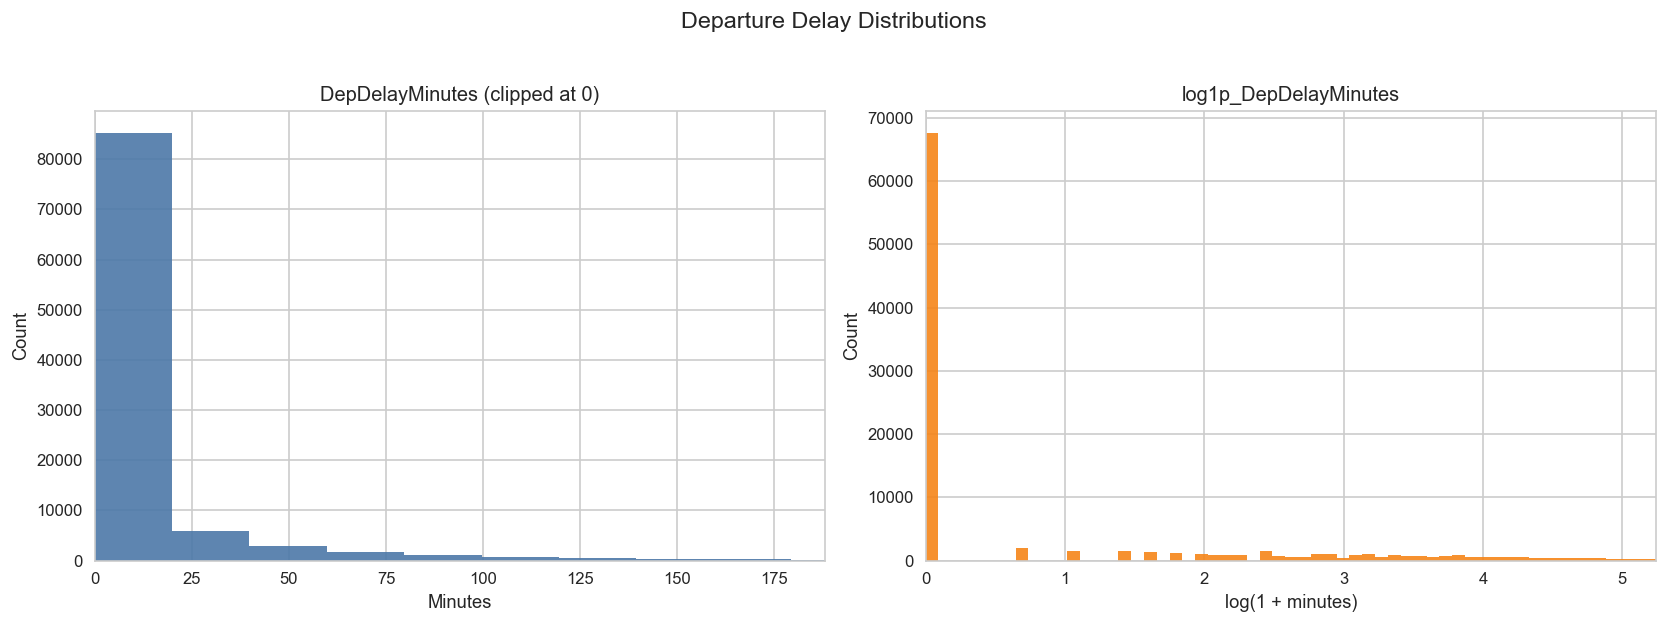

,metric,DepDelayMinutes,log1p_DepDelayMinutes
0,count,99996.000000,99996.000000
1,mean,12.674837,0.930897
2,median,0.000000,0.000000
3,p90,34.000000,3.555348
4,p99,188.000000,5.241747


In [ ]:
# Beautiful distribution plots: DepDelayMinutes vs log1p_DepDelayMinutes
import numpy as np
import matplotlib.pyplot as plt

# Pick the dataframe you want to visualize (route_features is created above).
df_plot = route_features.copy()

raw_col = "DepDelayMinutes"
log_col = "log1p_DepDelayMinutes"

if raw_col not in df_plot.columns:
    raise KeyError(f"Missing column: {raw_col}")

# Handle negatives safely: log1p is only defined for x > -1, and delays are usually >= 0.
raw = pd.to_numeric(df_plot[raw_col], errors="coerce")
raw_nonneg = raw.clip(lower=0)
df_plot[log_col] = np.log1p(raw_nonneg)

# For readability, clip x-axes to the 99th percentile (keeps long tails from flattening the plot).
raw_p99 = float(np.nanpercentile(raw_nonneg, 99)) if raw_nonneg.notna().any() else 0.0
log_p99 = float(np.nanpercentile(df_plot[log_col], 99)) if df_plot[log_col].notna().any() else 0.0

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

axes[0].hist(raw_nonneg.dropna(), bins=80, color="#4C78A8", alpha=0.9)
axes[0].set_title("DepDelayMinutes (clipped at 0)")
axes[0].set_xlabel("Minutes")
axes[0].set_ylabel("Count")
if raw_p99 > 0:
    axes[0].set_xlim(0, raw_p99)

axes[1].hist(df_plot[log_col].dropna(), bins=80, color="#F58518", alpha=0.9)
axes[1].set_title("log1p_DepDelayMinutes")
axes[1].set_xlabel("log(1 + minutes)")
axes[1].set_ylabel("Count")
if log_p99 > 0:
    axes[1].set_xlim(0, log_p99)

fig.suptitle("Departure Delay Distributions", y=1.03, fontsize=14)
plt.tight_layout()
plt.show()

# Quick sanity stats
display(pd.DataFrame({
    "metric": ["count", "mean", "median", "p90", "p99"],
    raw_col: [
        raw_nonneg.count(),
        raw_nonneg.mean(),
        raw_nonneg.median(),
        np.nanpercentile(raw_nonneg, 90),
        np.nanpercentile(raw_nonneg, 99),
    ],
    log_col: [
        df_plot[log_col].count(),
        df_plot[log_col].mean(),
        df_plot[log_col].median(),
        np.nanpercentile(df_plot[log_col], 90),
        np.nanpercentile(df_plot[log_col], 99),
    ],
}))

## Final Dataframe

After taking so much effort in order to engineer useful features, here is how the final dataframe looks like:

In [ ]:
fe = FeatureEngineeringDepDelay(sample_df)
engineered_df = fe.engineer_features()

In [ ]:
pd.set_option('display.max_columns', None)
engineered_df.head(2)

,IATA_Code_Operating_Airline,Distance,CRSElapsedTime,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,arr_date,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,departure_hour,departure_day,departure_month,departure_weekday,departure_is_weekend,departure_is_peak_hour,arrival_hour,arrival_day,arrival_month,arrival_weekday,arrival_is_weekend,arrival_is_peak_hour,average_delay,delay_stddev,on_time_rate,is_high_dep_congestion,is_high_arr_congestion,dep_congestion_bucket,arr_congestion_bucket,route,average_route_delay,delay_route_stddev,log1p_DepDelayMinutes,dep_congestion_x_precipitation,dep_congestion_x_wind_gusts,dep_congestion_x_snowfall,arr_congestion_x_precipitation,arr_congestion_x_wind_gusts,arr_congestion_x_snowfall,distance_x_dep_precipitation,distance_x_dep_wind_gusts_10m,distance_x_dep_snowfall,distance_x_arr_precipitation,distance_x_arr_wind_gusts_10m,distance_x_arr_snowfall,temperature_delta,abs_temperature_delta,apparent_temperature_delta,abs_apparent_temperature_delta,humidity_delta,abs_humidity_delta,pressure_delta,abs_pressure_delta,cloud_cover_delta,abs_cloud_cover_delta,dep_gust_factor,arr_gust_factor,congestion_delta
0,AS,605.0,115.0,0.0,0.0,0.0,6.725354,7.920000,0.0,0.0,20.049999,21.273323,994.155151,79.275009,1007.900024,2021-06-28 08:00:00-06:00,0.0,0.0,0.0,11.298495,24.84,0.0,0.0,16.6,15.752708,1006.069519,76.995392,1006.900024,6,28,6,0,0,1,8,28,6,0,0,1,7.989864,27.509865,0.833703,0,0,1,1,SEA-SMF,15.164557,33.433604,2.397895,0.0,221.760002,0.0,0.0,422.280003,0.0,0.0,4791.600046,0.0,0.0,15028.200092,0.0,3.449999,3.449999,5.520615,5.520615,2.279617,2.279617,1.000000,1.000000,0.0,0.0,1.177633,2.198523,11.0
1,UA,589.0,116.0,0.0,0.0,0.0,4.334974,12.599999,0.0,0.0,30.000000,33.580986,984.703918,57.510258,1013.900024,2019-09-15 18:00:00-06:00,0.0,0.0,0.0,15.188416,42.48,0.0,100.0,28.4,24.027100,840.228271,15.589545,1008.099976,17,15,9,6,1,1,18,15,9,6,1,1,15.128977,55.574644,0.792409,0,0,0,2,DSM-DEN,14.571429,43.199041,0.000000,0.0,113.399995,0.0,0.0,3185.999966,0.0,0.0,7421.399663,0.0,0.0,25020.719730,0.0,1.600000,1.600000,9.553886,9.553886,41.920712,41.920712,5.800049,5.800049,-100.0,100.0,2.906591,2.796868,-66.0


This concludes the feature engineering step. The next step is to train the model using the engineered features.

# Training the Model

In this notebook, we will use the engineered features to train a machine learning model to predict departure delays.

In [ ]:
# Executing this cell does some magic
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/FlightDelay

/content/drive/MyDrive/Colab Notebooks/FlightDelay


In [ ]:
cd ..

In [ ]:
%%capture
!pip install -r requirements.txt

In [ ]:
import pandas as pd
from models.src.LightGBM import LightGBM
from features.src.feature_engineering_depDelay import FeatureEngineeringDepDelay
from openmeteo_api.src.openmeteoapi.WeatherData import Weather
from openmeteo_api.src.openmeteoapi.APICaller import OpenMeteoAPICaller
from aeromarket_api.src.aeroapi_market.APICaller import APICaller
from aeromarket_api.src.aeroapi_market.Flights import Flights
from FlightWeather.src.FlightWeather import FlightWeather
from models.src.catboost import CatBoost
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from models.src.XGBoast import XGBoost
from models.src.RandomForest import RandomForest
from dotenv import load_dotenv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score


In [ ]:
sample_df = pd.read_parquet('./data/sample_df_v3.parquet')

## Handeling Missing Data

Before we train any model, it is a good idea to handle missing data earlier so we do not have bias in our prediction. Dropping missing data blindly could introduce some bias in our data, so it would be a better idea to decide how we handle them earlier. Lets first graph the missing data of the target variables.

In [ ]:
rows = []
s = sample_df["DepDelayMinutes"]
rows.append({
    "column": "DepDelayMinutes",
    "source": "sample_df",
    "missing_count": int(s.isna().sum()),
    "missing_%": float(s.isna().mean() * 100),
    "total_rows": int(len(s)),
})

missing_summary = pd.DataFrame(rows).sort_values(["missing_%", "missing_count"], ascending=False).reset_index(drop=True)
display(missing_summary)

,column,source,missing_count,missing_%,total_rows
0,DepDelayMinutes,sample_df,4,0.004,100000


We can see here that only 0.004% of the target variable `DepDelayMinutes` is missing. We can also check which rows are missing this data to see if there is any pattern.

In [ ]:
missing_mask = sample_df["DepDelayMinutes"].isna()
n_missing = int(missing_mask.sum())
n_total = int(len(sample_df))
print(f"Missing DepDelayMinutes: {n_missing} / {n_total} ({(n_missing/n_total)*100:.4f}%)")

key_cols = [c for c in ["IATA_Code_Operating_Airline", "Origin", "Dest", "dep_date_local", "arr_datetime", "Distance", "CRSElapsedTime"] if c in sample_df.columns]
if n_missing > 0:
    display(sample_df.loc[missing_mask, key_cols + ["DepDelayMinutes"]].reset_index(drop=True))

Missing DepDelayMinutes: 4 / 100000 (0.0040%)


,IATA_Code_Operating_Airline,Origin,Dest,dep_date_local,arr_datetime,Distance,CRSElapsedTime,DepDelayMinutes
0,9E,LGA,GSO,2018-04-30 15:00:00,2018-04-30 17:00:00,461.0,113.0,NaN
1,9E,RDU,LGA,2018-04-22 17:00:00,2018-04-22 18:00:00,431.0,109.0,NaN
2,9E,JFK,RIC,2018-04-27 19:00:00,2018-04-27 21:00:00,288.0,103.0,NaN
3,9E,JFK,RIC,2018-01-26 14:00:00,2018-01-26 16:00:00,288.0,104.0,NaN


As we can see here, all the missing values come from flights operated by "9E" airline. Depending on the amount of missing data and the importance of the feature, we can decide to either drop these rows or impute them with some value. In this case, since the amount of missing data is very small, we can safely drop these rows without introducing significant bias in our model.

In [ ]:
sample_df = sample_df[~missing_mask].reset_index(drop=True)

## Preparing the Data

As a first step, we will load the sample data and apply the feature engineering pipeline to prepare the data for modeling, and split the data into training and test sets.

In [ ]:
engineered_df = FeatureEngineeringDepDelay(sample_df).engineer_features()

In [ ]:
engineered_df.head()

,IATA_Code_Operating_Airline,Distance,CRSElapsedTime,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,...,abs_apparent_temperature_delta,humidity_delta,abs_humidity_delta,pressure_delta,abs_pressure_delta,cloud_cover_delta,abs_cloud_cover_delta,dep_gust_factor,arr_gust_factor,congestion_delta
0,AS,605.0,115.0,0.0,0.0,0.0,6.725354,7.920000,0.0,0.0,...,5.520615,2.279617,2.279617,1.000000,1.000000,0.0,0.0,1.177633,2.198523,11.0
1,UA,589.0,116.0,0.0,0.0,0.0,4.334974,12.599999,0.0,0.0,...,9.553886,41.920712,41.920712,5.800049,5.800049,-100.0,100.0,2.906591,2.796868,-66.0
2,UA,1222.0,176.0,0.0,0.0,0.0,13.708391,20.160000,0.0,56.0,...,0.033024,-44.060558,44.060558,-7.700012,7.700012,-40.0,40.0,1.470632,2.687936,6.0
3,ZW,632.0,140.0,0.0,0.0,0.0,12.964998,33.839996,43.0,51.0,...,2.528877,24.500969,24.500969,-10.800049,10.800049,-27.0,27.0,2.610104,1.778373,-73.0
4,OO,282.0,89.0,0.0,0.0,0.0,1.484318,16.199999,0.0,0.0,...,12.453232,-47.497303,47.497303,-0.400024,0.400024,0.0,0.0,10.914103,2.669635,-38.0


In [ ]:
target_col = "log1p_DepDelayMinutes"
X = engineered_df.drop(columns=[target_col])
y = engineered_df[target_col]

cat_cols = X.select_dtypes(include=["object"]).columns.to_list()

for c in cat_cols:
  X[c] = X[c].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 79996
Testing samples: 20000


## Linear Regression

As a baseline, we will first train a linear regression model. This will help us understand how well a simple model performs on this task.

In [ ]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(exclude=["object", "category"]).columns
print(f"Categorical columns: {cat_cols.tolist()}")

Categorical columns: ['IATA_Code_Operating_Airline', 'route']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lr", LinearRegression())
])

In [ ]:
%%capture
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = mse_lr**0.5
r2_lr = r2_score(y_test, y_pred)

print("LR RMSE:", rmse_lr)
print("LR R²:", r2_lr)

LR RMSE: 1.447590790367504
LR R²: 0.10423253009445532


These results basically say the linear regression baseline isn’t doing much yet.

- **MSE: ~2.09** is the average squared error on our target. Note: our target is `log1p_DepDelayMinutes`, so this MSE is on the *log1p(minutes)* scale (not minutes).
- A more intuitive version is **RMSE**: $\sqrt{2.09} \approx 1.45$ (still on the log1p scale).
- **$R^2: ~0.09$** means the model only explains about **9% of the variance** in the test set. In other words: it’s only slightly better than predicting a constant delay for every flight.

So: this is a solid “baseline check”, but it’s a sign we’ll probably need a more flexible model (like LightGBM) to capture the non-linear patterns in delays.

## LightGBM

Now that we’ve got a baseline with linear regression, we can switch to **LightGBM**.

LightGBM is a gradient-boosted decision tree model (basically: lots of small trees added together, where each new tree tries to fix the mistakes from the previous ones). The nice part for this problem is that it can pick up **non‑linear relationships** and **feature interactions** that a simple linear model will usually miss.

So the goal here isn’t to “perfectly tune” it yet — it’s to see if a stronger model can capture more signal in the engineered features and improve our metrics.

In our LightGBM class, we have set up the model with some basic parameters. We will train the model on the training set and evaluate it on the test set.

In [ ]:
lgm_custom = LightGBM()
cat_cols = X_train.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")

lgm_custom.fit(X_train, y_train, cat_cols=cat_cols, nfold=10, eval_train_metric=True)

[INFO] LightGBM - LightGBM model initialized with parameters: {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05, 'num_leaves': 31, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'seed': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'max_depth': -1, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_data_in_leaf': 20}
[INFO] LightGBM - Starting model training...


Training until validation scores don't improve for 20 rounds
[50]	train's rmse: 1.4092 + 0.000964394	valid's rmse: 1.42992 + 0.00829368
[100]	train's rmse: 1.37794 + 0.000965766	valid's rmse: 1.41863 + 0.00862381
[150]	train's rmse: 1.35657 + 0.00110601	valid's rmse: 1.41551 + 0.00914164
[200]	train's rmse: 1.33872 + 0.00128133	valid's rmse: 1.41422 + 0.00913825
[250]	train's rmse: 1.32256 + 0.00123971	valid's rmse: 1.41379 + 0.0093588
[300]	train's rmse: 1.30744 + 0.00114341	valid's rmse: 1.41333 + 0.00960345


[INFO] LightGBM - Best iteration from CV: 304


Early stopping, best iteration is:
[304]	train's rmse: 1.30632 + 0.00112015	valid's rmse: 1.41326 + 0.00961865


[INFO] LightGBM - Model training completed.


In [ ]:
y_pred = lgm_custom.predict(X_test)

In [ ]:
mse_lgbm = mean_squared_error(y_test, y_pred)
rmse_lgbm = mse_lgbm**0.5
r2_lgbm = r2_score(y_test, y_pred)

print("LightGBM RMSE:", rmse_lgbm)
print("LightGBM R²:", r2_lgbm)

LightGBM RMSE: 1.4135615655958562
LightGBM R²: 0.14585201528508407


These results show LightGBM is **clearly learning more signal** than our linear regression baseline.

- **RMSE: 1.414** on `log1p_DepDelayMinutes` (so the error is on the *log1p(minutes)* scale, not raw minutes).
- **$R^2: 0.146$** means the model explains about **14.6% of the variance** in the test set.

Compared to the baseline linear regression (RMSE ~$1.45$, $R^2$ ~$0.09$), LightGBM is an improvement: **lower error and higher explained variance**. That’s what we’d expect from boosted trees, since they can capture **non-linear effects** (e.g., weather impacts, airport/route effects, schedule interactions) and **feature interactions** that a linear model can’t.

## XGBoost

Now, we will train an XGBoost model using the same training and test sets. XGBoost is another powerful gradient-boosted decision tree model that often performs well on structured data tasks like this one.

In [ ]:
xgbm = XGBoost(use_gpu=False, enable_categorical=True, max_depth=10, learning_rate=0.01)
xgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    num_boost_round=2000,
    early_stopping_rounds=200,
    verbose_eval=False,
 )

y_pred_xgb = xgbm.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_xgb)

[INFO] XGBoost - XGBoost initialized with parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42, 'nthread': -1, 'tree_method': 'hist'}
[INFO] XGBoost - Starting XGBoost training...


We are here


[INFO] XGBoost - Training completed.


XGBoost RMSE: 1.477385917645829
XGBoost R²: 0.06697866641760086


These results basically say the XGBoost model **isn’t beating our baseline yet**.

- **RMSE: ~1.47** on `log1p_DepDelayMinutes` (so this is still on the *log1p(minutes)* scale, not raw minutes).
- **$R^2: ~0.066$** means it explains about **6–7% of the variance** in the test set.

So even though XGBoost *can* be a strong model for tabular data, right now it’s not finding much extra signal beyond what we already had (and it’s actually a bit worse than the linear regression baseline).

## Random Forest

Finally, we will train a Random Forest model using the same training and test sets. Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mean prediction of the individual trees.

In [ ]:
rf = RandomForest(
    n_trees=200,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=8,
    seed=42,
 )

rf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose_eval=False)
y_pred_rf_like = rf.predict(X_test)

mse_rf_like = mean_squared_error(y_test, y_pred_rf_like)
rmse_rf_like = mse_rf_like ** 0.5
r2_rf_like = r2_score(y_test, y_pred_rf_like)

print("XGB-RF RMSE:", rmse_rf_like)
print("XGB-RF R²:", r2_rf_like)

[INFO] RandomForest - RandomForest (XGB-RF) initialized with parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 1.0, 'num_parallel_tree': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 8, 'seed': 42, 'nthread': -1, 'tree_method': 'hist'}
[INFO] RandomForest - Starting RandomForest (XGB-RF) training...
[INFO] RandomForest - Training completed.


XGB-RF RMSE: 1.4801058119091801
XGB-RF R²: 0.06354008569722558


There results show that Random Forest is not performing any better than XGBoost or even Linear Regression.

## CatBoost

Finally, we will train a CatBoost model using the same training and test sets. CatBoost is another gradient-boosted decision tree model that is particularly good at handling categorical features. It is very similar to LightGBM and XGBoost in terms of functionality, but it has some unique features that make it stand out, such as its ability to handle categorical features natively without the need for one-hot encoding.

In [ ]:
# CatBoost


cb = CatBoost(
    use_gpu=False,
    iterations=5000,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=False,
 )

cb.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)
y_pred_cb = cb.predict(X_test)

mse_cb = mean_squared_error(y_test, y_pred_cb)
rmse_cb = mse_cb ** 0.5
r2_cb = r2_score(y_test, y_pred_cb)

print("CatBoost RMSE:", rmse_cb)
print("CatBoost R²:", r2_cb)

[INFO] CatBoost - CatBoost initialized with parameters: {'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_seed': 42, 'verbose': False, 'iterations': 5000, 'learning_rate': 0.05, 'depth': 8}
[INFO] CatBoost - Starting CatBoost training...
[INFO] CatBoost - Training completed.


CatBoost RMSE: 1.3976383434774091
CatBoost R²: 0.16498692191196362


In [ ]:
RMSES = {
    "Linear Regression": rmse_lr,
    "LightGBM": rmse_lgbm,
    "XGBoost": rmse_xgb,
    "CatBoost": rmse_cb,
    "XGB-RF": rmse_rf_like,
}
R2S = {
    "Linear Regression": r2_lr,
    "LightGBM": r2_lgbm,
    "XGBoost": r2_xgb,
    "CatBoost": r2_cb,
    "XGB-RF": r2_rf_like,
}
results_df = pd.DataFrame({
    "Model": RMSES.keys(),
    "RMSE": RMSES.values(),
    "R²": R2S.values(),
}).sort_values(by="RMSE").reset_index(drop=True)
display(results_df)

,Model,RMSE,R²
0,CatBoost,1.397638,0.164987
1,LightGBM,1.413562,0.145852
2,Linear Regression,1.447591,0.104233
3,XGBoost,1.477386,0.066979
4,XGB-RF,1.480106,0.063540


Given the results, CatBoost is performing the best. However, it is still not performing significantly better than LightGBM. We are expecting to use LightGBM given its faster training time compared to CatBoost in our actual deployment scenario.

## Classification

The regression models were stable and generally good, but they plateaued at relatively low R² values (≈ 0.10–0.16), even with non-linear tree-based methods. This suggests that while there is predictive signal in the data, the exact magnitude of departure delay is noisy and partially driven by unobserved operational factors.

To better align the modeling objective with the available signal, I will reframe the problem as a binary classification task: predicting whether a flight will experience a meaningful departure delay. This formulation reduces sensitivity to extreme outliers and focuses the model on learning stable delay patterns rather than precise delay values.

In [ ]:
dd = sample_df["DepDelayMinutes"]

bins = [-float("inf"), 14, 45, float("inf")]
labels = [ "1–14", "15–45", ">45"]
display(pd.cut(dd, bins=bins, labels=labels).value_counts().sort_index())

DepDelayMinutes
1–14     82714
15–45     9495
>45       7787
Name: count, dtype: int64

In [ ]:
train_cls_sample, test_cls_sample = train_test_split(
    sample_df, test_size=0.2, random_state=42, shuffle=True
 )

In [ ]:
engineered_df_class_train_sample = FeatureEngineeringDepDelay(train_cls_sample, classification=True).engineer_features()
engineered_df_class_test_sample = FeatureEngineeringDepDelay(test_cls_sample, classification=True, type="new").engineer_features(is_test=True)

target_col = "DepDelayCategory"

X_train_cls = engineered_df_class_train_sample.drop(columns=[target_col])
y_train_cls = engineered_df_class_train_sample[target_col].astype(int)

X_test_cls = engineered_df_class_test_sample.drop(columns=[target_col])
y_test_cls = engineered_df_class_test_sample[target_col].astype(int)
cat_cols = X_train_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train_cls[c] = X_train_cls[c].astype("category")
    X_test_cls[c] = X_test_cls[c].astype("category")


In [ ]:
engineered_df_class_train_sample.groupby('DepDelayCategory').size()

DepDelayCategory
0    75238
1     4758
dtype: int64

## LightGBM Classification

Our LightGBM Regression model showed promising results, so we will adapt it for classification. We will define meaningful delay categories and train the model to predict these classes.

In [ ]:
lgbm_cls = LightGBM(
    classification=True,
    objective="multiclass",
    metric="multi_logloss",
    num_class=3,
 )

lgbm_cls.fit(X_train_cls, y_train_cls, cat_cols=cat_cols, nfold=10, eval_train_metric=True)
y_pred_cls = lgbm_cls.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

[INFO] LightGBM - LightGBM model initialized with parameters: {'objective': 'multiclass', 'metric': 'multi_logloss', 'learning_rate': 0.05, 'num_leaves': 31, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'seed': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'max_depth': -1, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_data_in_leaf': 20, 'num_class': 3}
[INFO] LightGBM - Starting model training...


Training until validation scores don't improve for 20 rounds


[INFO] LightGBM - Best iteration from CV: 27


Early stopping, best iteration is:
[27]	train's multi_logloss: 0.17523 + 0.000309315	valid's multi_logloss: 0.198068 + 0.00241909


[INFO] LightGBM - Model training completed.


Accuracy: 0.9422
Confusion matrix:
 [[18834     0]
 [ 1156    10]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18834
           1       1.00      0.01      0.02      1166

    accuracy                           0.94     20000
   macro avg       0.97      0.50      0.49     20000
weighted avg       0.95      0.94      0.91     20000



### LightGBM (Multiclass) — Results

**Overall**
- **Accuracy:** `0.83415`
- **Test set size:** `20000`

**Class 0 vs Rest**
```text
                 Pred +      Pred -
Actual + (class 0)   TP=16647    FN=8
Actual - (not 0)     FP=3306     TN=39
```

**Class 1 vs Rest**
```text
                 Pred +      Pred -
Actual + (class 1)   TP=27       FN=2152
Actual - (not 1)     FP=7        TN=17814
```

**Class 2 vs Rest**
```text
                 Pred +      Pred -
Actual + (class 2)   TP=9        FN=1157
Actual - (not 2)     FP=4        TN=18830
```


**Notes**
- The model performs very well on **Class 0** (recall ≈ `1.00`).
- **Classes 1 and 2** have very low recall (≈ `0.01`), meaning the model rarely predicts these classes.

This is a known Problem in ML called Class Imbalance, where one class (here, Class 0) dominates the dataset, making it hard for the model to learn to predict the minority classes (Classes 1 and 2). To address this, we can try techniques like oversampling the minority classes, undersampling the majority class, or using class weights in the loss function to give more importance to the minority classes during training.

## Weighting Classes

The first step to address class imbalance is to weight the classes inversely proportional to their frequencies. This way, the model will pay more attention to the minority classes during training. Let's compute the class weights and retrain the LightGBM model with these weights.

In [ ]:
classes = np.unique(y_train_cls)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_cls
)

class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{np.int64(0): np.float64(0.5309703969202177),
 np.int64(1): np.float64(8.572224603514789)}

Now let's class weight to sample weights.

In [ ]:
sample_weights = y_train_cls.map(class_weight_dict)

Now, we will retrain the LightGBM model using the computed class weights to see if it improves performance on the minority classes.

In [ ]:
rng = 42

params = {
    "objective": "binary",
    "metric": "average_precision",
    "learning_rate": 0.03,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 1,
    "seed": 42,
    "verbose": -1,
}

lgbm_cls = LightGBM(
    classification=True,
    **params,
 )

lgbm_cls.fit(
    X_train_cls,
    y_train_cls,
    cat_cols=cat_cols,
    sample_weight=sample_weights,
    nfold=10,
    eval_train_metric=True,
 )
y_pred_cls = lgbm_cls.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

[INFO] LightGBM - LightGBM model initialized with parameters: {'objective': 'binary', 'metric': 'average_precision', 'learning_rate': 0.03, 'num_leaves': 63, 'feature_fraction': 0.85, 'bagging_fraction': 0.85, 'bagging_freq': 1, 'seed': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'max_depth': -1, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_data_in_leaf': 50}
[INFO] LightGBM - Starting model training...


Training until validation scores don't improve for 20 rounds


[INFO] LightGBM - Best iteration from CV: 5


Early stopping, best iteration is:
[5]	train's average_precision: 0.819008 + 0.00644439	valid's average_precision: 0.687325 + 0.01508


[INFO] LightGBM - Model training completed.


Accuracy: 0.68725
Confusion matrix:
 [[13047  5787]
 [  468   698]]
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     18834
           1       0.11      0.60      0.18      1166

    accuracy                           0.69     20000
   macro avg       0.54      0.65      0.49     20000
weighted avg       0.92      0.69      0.77     20000



Our goal of this model is to catch class 1. In this case, recall of class 1 is 0.58, which mean the model is able to identify 58% of the actual class 1 instances. Precision of 0.14 of class 1 means that when the model predicts class 1, it is correct 14% of the time and wrong 86% of the time. It is really not what we want yet, but it is a good improvement from before.

In [ ]:
conf = confusion_matrix(y_test_cls, y_pred_cls)

n_classes = int(conf.shape[0])
if n_classes == 2:
    class_labels = ["Not_Delayed", "Delayed"]
else:
    class_labels = [f"Class_{i}" for i in range(n_classes)]

conf_df = pd.DataFrame(
    conf,
    index=[f"Actual_{c}" for c in class_labels],
    columns=[f"Pred_{c}" for c in class_labels],
)

display(conf_df)

conf_df /conf.sum()

,Pred_Not_Delayed,Pred_Delayed
Actual_Not_Delayed,13179,5655
Actual_Delayed,498,668


,Pred_Not_Delayed,Pred_Delayed
Actual_Not_Delayed,0.65895,0.28275
Actual_Delayed,0.02490,0.03340


## CatBoost Classification

Now, we will retrain the CatBoost model using the computed class weights to see if it improves performance on the minority classes.

**Update**: Added Destination and Origin airport on-time rate features, and year features to help the model capture more patterns related to airport performance and temporal trends.

In [ ]:
engineered_df_class = FeatureEngineeringDepDelay(sample_df, classification=True).engineer_features()

target_col = "DepDelayCategory"

drop_cols = [c for c in [target_col, "log1p_DepDelayMinutes"] if c in engineered_df_class.columns]
X_cls = engineered_df_class.drop(columns=drop_cols)
y_cls = engineered_df_class[target_col].astype(int)

cat_cols = X_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_cls[c] = X_cls[c].astype("category")

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
 )

engineered_df_class.groupby('DepDelayCategory').size()

DepDelayCategory
0    94056
1     5940
dtype: int64

In [ ]:
params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 2000,
    "learning_rate": 0.03,
    "depth": 6,
    "l2_leaf_reg": 5,
    "subsample": 0.8,
    "auto_class_weights": "Balanced",
    "random_seed": 42,
    "verbose": False,
}


cb_cls = CatBoost(classification=True, **params)

cb_cls.fit(
    X_train_cls,
    y_train_cls,
    nfold=5,
    early_stopping_rounds=100)

y_pred = cb_cls.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred))
print(classification_report(y_test_cls, y_pred))

[INFO] CatBoost - CatBoost initialized with parameters: {'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_seed': 42, 'verbose': False, 'iterations': 2000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 5, 'subsample': 0.8, 'auto_class_weights': 'Balanced'}
[INFO] CatBoost - Running 5-fold CV to select iterations...


Training on fold [0/5]

bestTest = 0.8105831911
bestIteration = 484

Training on fold [1/5]

bestTest = 0.8093700947
bestIteration = 499

Training on fold [2/5]

bestTest = 0.8033359782
bestIteration = 488

Training on fold [3/5]

bestTest = 0.8244015065
bestIteration = 464

Training on fold [4/5]


[INFO] CatBoost - Starting CatBoost training (CV-selected iterations)...



bestTest = 0.8143189112
bestIteration = 505



[INFO] CatBoost - Training completed.


Accuracy: 0.718
Confusion matrix:
 [[13470  5342]
 [  298   890]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     18812
           1       0.14      0.75      0.24      1188

    accuracy                           0.72     20000
   macro avg       0.56      0.73      0.53     20000
weighted avg       0.93      0.72      0.79     20000



Note that in this model, we calculated the stats for all data, including training and test sets. This is data leakage and should not be done in practice. However, this gives us an idea of the best possible performance we can achieve with this model. Given that we will train on a huge dataset later, we expect the model to perform better.

In [ ]:
y_score = cb_cls.predict(X_test_cls, prediction_type='Probability')[:, 1]
y_score

array([0.4761003 , 0.59979521, 0.65275019, ..., 0.47542734, 0.40653235,
       0.46209699], shape=(20000,))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_cls, y_score)
auc = roc_auc_score(y_test_cls, y_score)

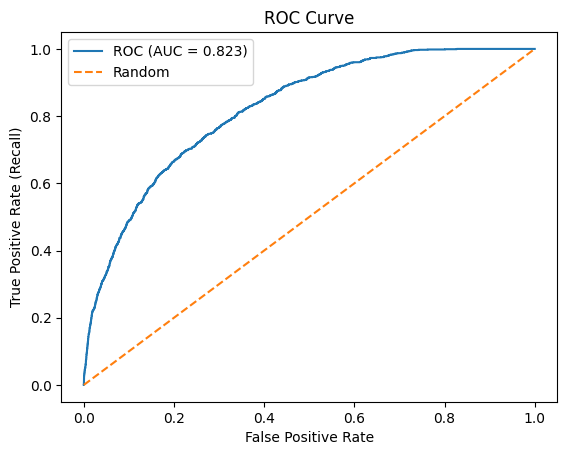

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

Now we want to increase the precision of class 1, at the price of recall. We can do this by adjusting the decision threshold.

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred_proba = cb_cls.predict(X_test_cls, prediction_type="Probability")
class_1_proba = y_pred_proba[:, 1]
y_test_binary = (y_test_cls == 1).astype(int)

for threshold in list(np.arange(0.4, 0.9, 0.02)):
    y_pred = (class_1_proba >= threshold).astype(int)
    precision = precision_score(y_test_binary, y_pred, zero_division=0)
    recall = recall_score(y_test_binary, y_pred, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred, zero_division=0)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Threshold: 0.40, Precision: 0.1107, Recall: 0.8729, F1: 0.1965
Threshold: 0.42, Precision: 0.1150, Recall: 0.8485, F1: 0.2026
Threshold: 0.44, Precision: 0.1188, Recall: 0.8190, F1: 0.2075
Threshold: 0.46, Precision: 0.1246, Recall: 0.7988, F1: 0.2156
Threshold: 0.48, Precision: 0.1329, Recall: 0.7803, F1: 0.2272
Threshold: 0.50, Precision: 0.1406, Recall: 0.7534, F1: 0.2370
Threshold: 0.52, Precision: 0.1484, Recall: 0.7231, F1: 0.2463
Threshold: 0.54, Precision: 0.1574, Recall: 0.6919, F1: 0.2564
Threshold: 0.56, Precision: 0.1712, Recall: 0.6667, F1: 0.2724
Threshold: 0.58, Precision: 0.1815, Recall: 0.6254, F1: 0.2814
Threshold: 0.60, Precision: 0.1972, Recall: 0.5850, F1: 0.2949
Threshold: 0.62, Precision: 0.2145, Recall: 0.5463, F1: 0.3080
Threshold: 0.64, Precision: 0.2267, Recall: 0.4891, F1: 0.3098
Threshold: 0.66, Precision: 0.2427, Recall: 0.4394, F1: 0.3127
Threshold: 0.68, Precision: 0.2638, Recall: 0.3931, F1: 0.3158
Threshold: 0.70, Precision: 0.2845, Recall: 0.3468, F1:

Now we can build our final model.

In [ ]:
import numpy as np

class DelayClassifier:
    def __init__(self, model, threshold=0.6):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict(X, prediction_type="Probability")[:, 1]

    def predict(self, X):
        return (self.predict_proba(X) >= self.threshold).astype(int)

delay_classifier = DelayClassifier(cb_cls, threshold=0.60)

y_pred_cls = delay_classifier.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.83385
Confusion matrix:
 [[15982  2830]
 [  493   695]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     18812
           1       0.20      0.59      0.29      1188

    accuracy                           0.83     20000
   macro avg       0.58      0.72      0.60     20000
weighted avg       0.92      0.83      0.87     20000



Let say we want to predict a flight that going from Baltimore to Denver on January 12 (in 6 days). We will need to call the FlightWeather class wrapper in order to get the weather and flight data.

In [ ]:
flightWeather = FlightWeather(flight_num="UA 2012", flight_date="2026-01-12")

In [ ]:
flight_df = flightWeather.get_full_data()

Fetching weather data from: https://api.open-meteo.com/v1/forecast
Successfully fetched data for 2 airport(s).


In [ ]:
set(sample_df.drop(columns=["DepDelayMinutes", 'arr_date']).columns) == set(flight_df.columns)

True

In my feature engineering class, I save .pkl files for stats about airlines, airports, and routes. When I predict a new feature, I can set type = "new", and the files will be loaded and attached to the new flight. When I load these .pkl files, I make sure to handle any unknown categories by filling in missing values with statistics for an "__UNKNOWN__" category. This way, if the flight data includes an airline, airport, or route that wasn't seen during training, the model can still make a reasonable prediction using the average statistics for unknown categories.

In [ ]:
import pickle
with open('./data/route_stats.pkl', 'rb') as f:
    route_stats = pickle.load(f)

In [ ]:
flight_df_engineered = FeatureEngineeringDepDelay(flight_df, type="new").engineer_features()
flight_df_engineered

,IATA_Code_Operating_Airline,Distance,CRSElapsedTime,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,departure_hour,departure_day,departure_month,departure_weekday,departure_is_weekend,departure_is_peak_hour,arrival_hour,arrival_day,arrival_month,arrival_weekday,arrival_is_weekend,arrival_is_peak_hour,average_delay,delay_stddev,on_time_rate,is_high_dep_congestion,is_high_arr_congestion,dep_congestion_bucket,arr_congestion_bucket,route,average_route_delay,delay_route_stddev,dep_congestion_x_precipitation,dep_congestion_x_wind_gusts,dep_congestion_x_snowfall,arr_congestion_x_precipitation,arr_congestion_x_wind_gusts,arr_congestion_x_snowfall,distance_x_dep_precipitation,distance_x_dep_wind_gusts_10m,distance_x_dep_snowfall,distance_x_arr_precipitation,distance_x_arr_wind_gusts_10m,distance_x_arr_snowfall,temperature_delta,abs_temperature_delta,apparent_temperature_delta,abs_apparent_temperature_delta,humidity_delta,abs_humidity_delta,pressure_delta,abs_pressure_delta,cloud_cover_delta,abs_cloud_cover_delta,dep_gust_factor,arr_gust_factor,congestion_delta
0,UA,1491.0,220.0,0.0,0.0,0.0,16.055355,25.559999,0.0,2.0,5.111,-0.563633,1020.597168,30.0,1026.5,0.0,0.0,0.0,11.570515,16.559999,0.0,8.0,1.2005,-3.277061,839.25769,63.0,1024.199951,16,12,1,0,0,1,18,12,1,0,0,1,15.128977,55.574644,0.792409,0,1,1,3,BWI-DEN,12.081081,16.535111,0.0,638.999987,0.0,0.0,1838.159941,0.0,0.0,38109.959204,0.0,0.0,24690.959204,0.0,3.9105,3.9105,2.713428,2.713428,-33.0,33.0,2.300049,2.300049,-6.0,6.0,1.591992,1.431224,-86


In [ ]:
route_stats.loc['BWI-DEN']

average_route_delay    12.081081
delay_route_stddev     16.535111
Name: BWI-DEN, dtype: float64

In [ ]:
BTW_DEN_pred = cb_cls.predict(flight_df_engineered, prediction_type="Probability")

In [ ]:
BTW_DEN_pred

array([[0.65752067, 0.34247933]])

Based On this results, the model predicted that the flight has a 75% chance of being in class 0 (on time), a 20% chance of being in class 1 (60 minutes delayed). Is not that amazing?

We can now save the model for future use.

In [ ]:
with open('./data/catboost_sample_model.pkl', 'wb') as f:
    pickle.dump(cb_cls, f)

Then Use it again later by loading it from the .pkl file.

In [ ]:
with open('./data/catboost_sample_model.pkl', 'rb') as f:
    cb_loaded = pickle.load(f)
cb_loaded.predict(flight_df_engineered, prediction_type="Probability")

array([[0.74138222, 0.25861778]])

## Training on GPUs

We already trained the LightGBM and CatBoost models on CPU, and we showed that CatBoost performed slightly better than LightGBM for our classification task. However, our model got low precision for class 1, which means that out of all delayed flights predicted by the model, only a small fraction were actually delayed. This is not ideal for our use case, as we want to minimize false positives (i.e., predicting a flight will be delayed when it is not). Maybe a better solution would be to train the model on GPUs, which can handle larger datasets and more complex models more efficiently than CPUs. By leveraging the parallel processing capabilities of GPUs, we can potentially improve the model's performance and achieve better precision for class 1.

In [ ]:
full_df = pd.read_parquet('./data/full_df_v3.parquet')

## Handeling Missing Data

Before we train any model, it is a good idea to handle missing data earlier so we do not have bias in our prediction. Dropping missing data blindly could introduce some bias in our data, so it would be a better idea to decide how we handle them earlier. Lets first graph the missing data of the target variables.

In [ ]:
rows = []
s = full_df["DepDelayMinutes"]
rows.append({
    "column": "DepDelayMinutes",
    "source": "full_df",
    "missing_count": int(s.isna().sum()),
    "missing_%": float(s.isna().mean() * 100),
    "total_rows": int(len(s)),
})

missing_summary = pd.DataFrame(rows).sort_values(["missing_%", "missing_count"], ascending=False).reset_index(drop=True)
display(missing_summary)

,column,source,missing_count,missing_%,total_rows
0,DepDelayMinutes,full_df,1113,0.003917,28416515


We can see here that only 0.004% of the target variable `DepDelayMinutes` is missing. We can also check which rows are missing this data to see if there is any pattern.

In [ ]:
missing_mask = full_df["DepDelayMinutes"].isna()
n_missing = int(missing_mask.sum())
n_total = int(len(full_df))
print(f"Missing DepDelayMinutes: {n_missing} / {n_total} ({(n_missing/n_total)*100:.4f}%)")

key_cols = [c for c in ["IATA_Code_Operating_Airline", "Origin", "Dest", "dep_date_local", "arr_datetime", "Distance", "CRSElapsedTime"] if c in full_df.columns]
if n_missing > 0:
    display(full_df.loc[missing_mask, key_cols + ["DepDelayMinutes"]].reset_index(drop=True))

Missing DepDelayMinutes: 1113 / 28416515 (0.0039%)


,IATA_Code_Operating_Airline,Origin,Dest,dep_date_local,arr_datetime,Distance,CRSElapsedTime,DepDelayMinutes
0,9E,ABY,ATL,2018-01-28 12:00:00,2018-01-28 13:00:00,145.0,62.0,NaN
1,9E,ATL,MOB,2018-01-02 08:00:00,2018-01-02 08:00:00,302.0,89.0,NaN
2,9E,BTV,DTW,2018-01-07 12:00:00,2018-01-07 14:00:00,537.0,135.0,NaN
3,9E,ATL,EWN,2018-01-10 12:00:00,2018-01-10 13:00:00,433.0,85.0,NaN
4,9E,ATL,EWN,2018-01-23 12:00:00,2018-01-23 13:00:00,433.0,85.0,NaN
...,...,...,...,...,...,...,...,...
1108,9E,CLT,JFK,2018-04-20 11:00:00,2018-04-20 13:00:00,541.0,137.0,NaN
1109,F9,GRR,DEN,2018-06-05 19:00:00,2018-06-05 19:00:00,1015.0,178.0,NaN
1110,F9,MCO,OKC,2018-06-09 18:00:00,2018-06-09 21:00:00,1069.0,190.0,NaN
1111,F9,MCO,AUS,2018-07-27 18:00:00,2018-07-27 20:00:00,994.0,174.0,NaN


In [ ]:
full_df[missing_mask]['IATA_Code_Operating_Airline'].unique()

array(['9E', 'F9'], dtype=object)

As we can see here, all the missing values come from flights operated by "9E", and "F9" airline. Depending on the amount of missing data and the importance of the feature, we can decide to either drop these rows or impute them with some value. In this case, since the amount of missing data is very small, we can safely drop these rows without introducing significant bias in our model.

In [ ]:
full_df = full_df[~missing_mask].reset_index(drop=True)

We need to calculate stats on the training data only, so we will split the full dataset into training and test sets before calculating the stats. This way, we can ensure that the stats are not biased by the test data, and we can get a more accurate estimate of the model's performance on unseen data.

In [ ]:
train_cls, test_cls = train_test_split(
    full_df, test_size=0.2, random_state=42, shuffle=True
 )

In [ ]:
engineered_df_class_train = FeatureEngineeringDepDelay(train_cls, classification=True).engineer_features()
engineered_df_class_test = FeatureEngineeringDepDelay(test_cls, classification=True, type="new").engineer_features(is_test=True)

target_col = "DepDelayCategory"

X_train_cls = engineered_df_class_train.drop(columns=[target_col])
y_train_cls = engineered_df_class_train[target_col].astype(int)

X_test_cls = engineered_df_class_test.drop(columns=[target_col])
y_test_cls = engineered_df_class_test[target_col].astype(int)

cat_cols = X_train_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train_cls[c] = X_train_cls[c].astype("category")
    X_test_cls[c] = X_test_cls[c].astype("category")


In [ ]:
engineered_df_class_train.to_parquet('./data/engineered_df_class_train.parquet')
engineered_df_class_test.to_parquet('./data/engineered_df_class_test.parquet')

In [ ]:
engineered_df_class_train = pd.read_parquet('./data/engineered_df_class_train.parquet')
engineered_df_class_test = pd.read_parquet('./data/engineered_df_class_test.parquet')

In [ ]:
target_col = "DepDelayCategory"

X_train_cls = engineered_df_class_train.drop(columns=[target_col])
y_train_cls = engineered_df_class_train[target_col].astype(int)

X_test_cls = engineered_df_class_test.drop(columns=[target_col])
y_test_cls = engineered_df_class_test[target_col].astype(int)

cat_cols = X_train_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train_cls[c] = X_train_cls[c].astype("category")
    X_test_cls[c] = X_test_cls[c].astype("category")

In [ ]:
n_classes = int(pd.Series(y_train_cls).nunique())
is_binary = n_classes == 2

params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 7000,
    "learning_rate": 0.05,
    "depth": 8,
    "random_seed": 42,
    "auto_class_weights": "Balanced",
    "verbose": 200,
    "task_type": "GPU",
    "devices": "0:1",
}



cb_gpu_cls = CatBoost(use_gpu=True, classification=True, **params)
cb_gpu_cls.fit(
    X_train_cls,
    y_train_cls,
    nfold=5,
    early_stopping_rounds=200,
 )

y_pred_gpu = cb_gpu_cls.predict(X_test_cls)
print("Accuracy:", accuracy_score(y_test_cls, y_pred_gpu))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_gpu))
print(classification_report(y_test_cls, y_pred_gpu))

[INFO] CatBoost - CatBoost initialized with parameters: {'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_seed': 42, 'verbose': 200, 'task_type': 'GPU', 'iterations': 7000, 'learning_rate': 0.05, 'depth': 8, 'auto_class_weights': 'Balanced', 'devices': '0:1'}
[INFO] CatBoost - Running 5-fold CV to select iterations...
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.7336420417
bestIteration = 2579
Training on fold [1/5]
bestTest = 0.7349703312
bestIteration = 2906
Training on fold [2/5]
bestTest = 0.7391571999
bestIteration = 6899
Training on fold [3/5]
bestTest = 0.7389928699
bestIteration = 5500
Training on fold [4/5]


[INFO] CatBoost - Starting CatBoost training (CV-selected iterations)...


bestTest = 0.7403656244
bestIteration = 6912


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6747595	best: 0.6747595 (0)	total: 365ms	remaining: 8m 24s
200:	test: 0.7301756	best: 0.7301756 (200)	total: 1m 15s	remaining: 7m 24s
400:	test: 0.7405070	best: 0.7405070 (400)	total: 2m 27s	remaining: 6m 2s
600:	test: 0.7456531	best: 0.7456531 (600)	total: 3m 38s	remaining: 4m 44s
800:	test: 0.7492343	best: 0.7492343 (800)	total: 4m 49s	remaining: 3m 30s
1000:	test: 0.7517298	best: 0.7517298 (1000)	total: 5m 59s	remaining: 2m 17s
1200:	test: 0.7536491	best: 0.7536491 (1200)	total: 7m 8s	remaining: 1m 5s
1383:	test: 0.7551995	best: 0.7551995 (1383)	total: 8m 12s	remaining: 0us
bestTest = 0.755199492
bestIteration = 1383


[INFO] CatBoost - Training completed.


Accuracy: 0.7008084171244436
Confusion matrix:
 [[3753991 1588912]
 [ 111418  228760]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.82   5342903
           1       0.13      0.67      0.21    340178

    accuracy                           0.70   5683081
   macro avg       0.55      0.69      0.51   5683081
weighted avg       0.92      0.70      0.78   5683081



In [ ]:
import pickle
with open('./data/catboost_full_model_v2.pkl', 'wb') as f:
    pickle.dump(cb_gpu_cls, f)

In [ ]:
import pickle
with open('./data/catboost_full_model_v2.pkl', 'rb') as f:
    cb_cls = pickle.load(f)

The current model has low precision for class 1, meaning many false positives. We can improve precision by adjusting the classification threshold - instead of using class 0.5, we can use a higher threshold that's more conservative about predicting class 1. This trades off some recall for better precision.

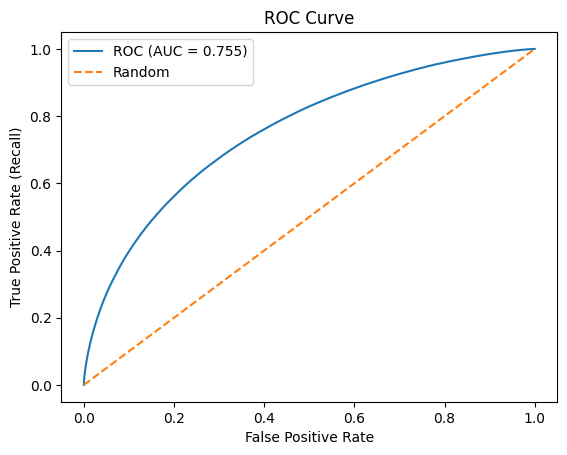

In [ ]:
y_score = cb_cls.predict(X_test_cls, prediction_type='Probability')[:, 1]
y_score

fpr, tpr, thresholds = roc_curve(y_test_cls, y_score)
auc = roc_auc_score(y_test_cls, y_score)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:

y_pred_proba = cb_gpu_cls.predict(X_test_cls, prediction_type="Probability")
class_1_proba = y_pred_proba[:, 1]
y_test_binary = (y_test_cls == 1).astype(int)

for threshold in list(np.arange(0.4, 0.9, 0.02)):
    y_pred = (class_1_proba >= threshold).astype(int)
    precision = precision_score(y_test_binary, y_pred, zero_division=0)
    recall = recall_score(y_test_binary, y_pred, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred, zero_division=0)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Threshold: 0.40, Precision: 0.0979, Recall: 0.8154, F1: 0.1748
Threshold: 0.42, Precision: 0.1026, Recall: 0.7896, F1: 0.1816
Threshold: 0.44, Precision: 0.1077, Recall: 0.7623, F1: 0.1888
Threshold: 0.46, Precision: 0.1134, Recall: 0.7341, F1: 0.1964
Threshold: 0.48, Precision: 0.1193, Recall: 0.7039, F1: 0.2041
Threshold: 0.50, Precision: 0.1259, Recall: 0.6725, F1: 0.2120
Threshold: 0.52, Precision: 0.1330, Recall: 0.6404, F1: 0.2202
Threshold: 0.54, Precision: 0.1406, Recall: 0.6072, F1: 0.2283
Threshold: 0.56, Precision: 0.1488, Recall: 0.5729, F1: 0.2362
Threshold: 0.58, Precision: 0.1578, Recall: 0.5387, F1: 0.2441
Threshold: 0.60, Precision: 0.1673, Recall: 0.5035, F1: 0.2512
Threshold: 0.62, Precision: 0.1780, Recall: 0.4687, F1: 0.2580
Threshold: 0.64, Precision: 0.1893, Recall: 0.4327, F1: 0.2634
Threshold: 0.66, Precision: 0.2018, Recall: 0.3970, F1: 0.2676
Threshold: 0.68, Precision: 0.2153, Recall: 0.3612, F1: 0.2698
Threshold: 0.70, Precision: 0.2300, Recall: 0.3251, F1:

## Threshold Selection


We set the classification threshold to 0.54, which yields a recall of approximately 0.61 for the 1-hour delay class. This means that 61% of flights that are truly delayed by at least one hour are correctly identified by the model.

At this threshold, the precision is approximately 14%, indicating that when the model predicts a 1-hour delay, the prediction is correct 14% of the time. While this results in a higher number of false positives, this trade-off is intentional.


The objective of the model is early risk awareness rather than exact delay confirmation. In an operational setting, it is preferable to flag potential delays early, even at the cost of additional false alarms, than to miss a significant delay entirely. As such, getting higher recall aligns better with the intended use case of proactive delay awareness.


## Creating the new model

In [ ]:
import numpy as np

class DelayClassifier:
    def __init__(self, model, threshold=0.6):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict(X, prediction_type="Probability")[:, 1]

    def predict(self, X):
        return (self.predict_proba(X) >= self.threshold).astype(int)

delay_classifier_final = DelayClassifier(cb_cls, threshold=0.54)

y_pred_cls = delay_classifier_final.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.7543520847230578
Confusion matrix:
 [[4080501 1262402]
 [ 133635  206543]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85   5342903
           1       0.14      0.61      0.23    340178

    accuracy                           0.75   5683081
   macro avg       0.55      0.69      0.54   5683081
weighted avg       0.92      0.75      0.82   5683081



Note that the overall accuracy of the model is approximately 0.60. This is expected and acceptable for this task. Our goal is not to maximize accuracy, but rather to detect as many true delays as possible, particularly severe delays of one hour or more.

If we wanted to maximized accuracy, we can do this:

In [ ]:
import numpy as np

class DelayClassifier:
    def __init__(self, model, threshold=0.6):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict(X, prediction_type="Probability")[:, 1]

    def predict(self, X):
        return (self.predict_proba(X) >= self.threshold).astype(int)

delay_classifier_final_accuracy = DelayClassifier(cb_gpu_cls, threshold=1)

y_pred_cls = delay_classifier_final_accuracy.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.9401419758050255
Confusion matrix:
 [[5342903       0]
 [ 340178       0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97   5342903
           1       0.00      0.00      0.00    340178

    accuracy                           0.94   5683081
   macro avg       0.47      0.50      0.48   5683081
weighted avg       0.88      0.94      0.91   5683081



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Here, we made the model predect not delay for all data points, and got an accuracy of 94%. Because simply 94% of our data is not delayed. Now we can save our model and deploy it.

In [ ]:
import pickle
with open('./data/delay_classifier_final.pkl', 'wb') as f:
    pickle.dump(delay_classifier_final, f)

In [ ]:
import pickle
# read pickle file
with open('./data/catboost_full_model_v2.pkl', 'rb') as f:
    delay_classifier_loaded = pickle.load(f)

In [ ]:
from models.src.DelayClassifier import DelayClassifier
import joblib

delay_classifier = DelayClassifier(cb_cls, threshold=0.54)
joblib.dump(delay_classifier, "models/delay_classifier_final.pkl")

['models/delay_classifier_final.pkl']

Let say we want to predict a flight that going from Baltimore to Denver on January 12 (in 6 days). We will need to call the FlightWeather class wrapper in order to get the weather and flight data.

In [ ]:
flightWeather = FlightWeather(flight_num="UA 2012", flight_date="2026-01-12")

In [ ]:
load_dotenv()

True

In [ ]:
flight_df = flightWeather.get_full_data()

Fetching weather data from: https://api.open-meteo.com/v1/forecast
Successfully fetched data for 2 airport(s).


In [ ]:
flight_df_engineered = FeatureEngineeringDepDelay(flight_df, type="new").engineer_features()

In [ ]:
BTW_DEN_pred_prob = delay_classifier.predict_proba(flight_df_engineered)

In [ ]:
BTW_DEN_pred = delay_classifier.predict(flight_df_engineered)

In [ ]:
display(BTW_DEN_pred, BTW_DEN_pred_prob)

array([0])

array([0.1911873])

The model predicts no high risk of a one-hour delay for this flight.
The estimated probability of a one-hour delay is approximately 19%, which is below the selected risk threshold of 0.44.

As a result, this flight is classified as low delay risk. While delays are still possible, the model does not flag this flight as requiring heightened awareness compared to higher-risk cases.

## Summary

In this notebook, an end-to-end machine learning pipeline was developed to model flight delay behavior using historical flight operations data enriched with engineered operational and weather features. The analysis demonstrated that predicting delays is inherently challenging due to high class imbalance, noisy real-world signals, and overlapping patterns between delayed and non-delayed flights.

Through experimentation with multiple modeling approaches, it became clear that accuracy alone is not a reliable metric for this problem. Models that achieved high accuracy often failed to identify delayed flights effectively. As a result, evaluation shifted toward recall, precision, F1-score, ROC-AUC, and balanced accuracy, which better reflect real operational risk.

Tree-based ensemble models showed improved performance over linear baselines, particularly when combined with class weighting, probability outputs, and decision-threshold tuning. Rather than treating the task as a strict binary decision, modeling delay risk as a probability proved more informative and practical for downstream use cases such as risk tiering, operational planning, or alerting systems.

Overall, this project highlights the importance of problem formulation, metric selection, and interpretability when working with large-scale, imbalanced datasets. While perfect prediction is not achievable given the stochastic nature of flight delays, the resulting models provide meaningful insights and a solid foundation for risk-aware decision support systems in aviation operations.